In [1]:
import numpy
import torch
import sys
print("Numpy version: ", numpy.__version__)
print("Torch version: ", torch.__version__)
print("Python version: ", sys.version)

Numpy version:  2.2.6
Torch version:  2.7.0+cu118
Python version:  3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [2]:
import wandb
wandb.login()  
PROJECT_NAME = "RL-Portfolio-Management"

wandb: Currently logged in as: richardpogoson (richardpogoson-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1. Collect Basic Data

### 1.1. Read/Download Market Data ###

In [3]:
import pandas as pd
import yfinance as yf
from functools import reduce
import numpy as np
import torch
import requests
import time
import numpy as np
import talib as ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

RETRIEVE_DATA = False
"""
NOTE ON DATA CONSISTENCY:
Yahoo finance value precision still a problem, but can be partly mitigated by rounding prices to 2dp.
I tried rounding indicators to 4 significant figures. 4 is arbitrary, but higher values
will likely lead to more instability.
Later testing revealed that these mitigation techniques helped a bit, but were not perfect. I did my best.

# DATA LAST RETRIEVED - MAY 26th 2025 - Added rounding for close prices and sigFigs
"""

def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"  # same periods as that used by Zou et al. (2024)
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)

        # To have a more reliable indicator implementation. Mine were fine I believe, but the below is safer.
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]].copy()
        
        #Also round to 2dp to help reduce instability
        ohlcData[ticker][["Low", "High", "Open", "Close"]] = ohlcData[ticker][["Low", "High", "Open", "Close"]].round(2)

        high = np.round(stockData["High"].values.astype(np.float64).flatten(), 2)
        low = np.round(stockData["Low"].values.astype(np.float64).flatten(), 2)
        close = np.round(stockData["Close"].values.astype(np.float64).flatten(), 2)

        ohlcData[ticker]["ATR"] = ta.ATR(high, low, close, timeperiod=14)
        ohlcData[ticker]["Momentum"] = ta.MOM(close, timeperiod=1) # Momentum is used by Soleymani, not (RoC=Momentum Oscillator, my mistake)
        ohlcData[ticker]["CCI"] = ta.CCI(high, low, close, timeperiod=20)
        macd, signal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        ohlcData[ticker]["MACD"] = macd # histogram isn't the same as the MACD line, also used by Zou, not Soleymani
        ohlcData[ticker]["EMA"] = ta.EMA(close, timeperiod=30) 

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc

def roundToSf(array, sigFigs=4):
    """
    Round a NumPy array or Pandas Series to the specified number of significant figures
    Decision of 4 sigfigs is arbitrary, but higher values will likely lead to instability.
    """
    return np.array([
        round(x, sigFigs - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0 
        for x in array
    ])

def postProcessIndicators(df, columns):
    """
    Post-processes indicators - turns them to 4sf to promote stability
    """
    dfRounded = df.copy()
    for col in columns:
        if col in dfRounded.columns:
            dfRounded[col] = roundToSf(dfRounded[col])
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return dfRounded


dataframes = dict()


if RETRIEVE_DATA:
    for productId in productIds:
        """
        I was previously working with Crypto data also, so I implemented this to ensure
        column names are consistent across all dataframes.
        """
        dataframe = retrieveIndexData(ticker=productId)
        columnNames = [value[1] for value in list(dataframe.columns.values)]
        dataframe.columns = columnNames
        dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseAndPreprocess(data):
    """
    Returns data, ensures that all dataframes have the same index (dates).
    Also post-processes indicators returns 4 sigfigs.
    """
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    data = {ticker: postProcessIndicators(df, columns= ["ATR", "Momentum", "CCI", "MACD", "EMA"]) for ticker, df in data.items()}
    return data

if RETRIEVE_DATA:
    dataframes = commonaliseAndPreprocess(dataframes)

## ~~2. Augment Market Data With Indicators~~ - NOT REQUIRED, USING TALIB

## 3. Write/Load Dataframes to/from files

In [4]:
import os

if RETRIEVE_DATA:
    for product in productIds:
        """
        Generating dataframe for each product. Stored as marketdata.
        Now using reliable implementations of indicators from TA-Lib, as opposed to doing it myself.
        No longer have unstable indicators at the start of the dataframe, so we have 20 extra rows in total.
        """
        df = dataframes[product]
        df = df.drop(columns=['Open', 'High', 'Volume', 'Low'])
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first (index) column

times = None
for product in productIds:
    """
    Dropping the times column - is not required for training.
    """
    df = dataframes[product]
    times = df['Times']
    dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### 4.0.1. Comparison Strategies

In [5]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

"""
Non-RL Comparison Strategies
These are flat allocations across each of the respective indices.
"""
NON_RL_COMPARISON_STRATEGIES = {
    "SSE Buy-and-Hold": sse50BuyAndHold,
    "SENSEX Buy-and-Hold": sensexBuyAndHold,
    "FTSE 100 Buy-and-Hold": ftse100BuyAndHold,
    "DOW Buy-and-Hold": dowBuyAndHold,
    "Buy-and-Hold All": buyAndHoldAll
}

### 4.0.2. Hyperparameters and Global Variables

In [6]:
from collections import defaultdict
import torch

BASE_SEED = 9
NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (1 + len((list(dataframes.values())[0]).columns)) * len(productIds) + 1
PERIODS_WANTED = list(dataframes.values())[0].shape[0]
TRAINING_PERIODS = round(PERIODS_WANTED * 2 / 3)
VALIDATION_PERIODS = (PERIODS_WANTED - TRAINING_PERIODS) // 2
TESTING_PERIODS = VALIDATION_PERIODS


EPISODE_LENGTH = PERIODS_WANTED // 3 
TIMESTEP_SHIFT = EPISODE_LENGTH // 10
TRAINING_WINDOWS = ((TRAINING_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1


EPOCHS = 3
TIME_WINDOW = 30
PERTURBATION_NOISE = 0.01

SUM_TRAINING_PERIODS = TRAINING_WINDOWS * EPOCHS * (EPISODE_LENGTH - TIME_WINDOW) # because first time window steps are not used to learn
START_CASH = 10000  #lower for floating point precision of torch
LSTMHIDDENSIZE = 128

BASELINE = ["RANDOM"]
RL_STRATS = ["PPOLSTM"]
FINAL_STRATEGIES = BASELINE + list(NON_RL_COMPARISON_STRATEGIES.keys())
VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]

AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #Different risk aversion parameters for the agent when using CVaR reward
LSTMOUTPUTSIZES = [32, 64, 128, 256, 512]
REWARD_FUNCTIONS = ["Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1"]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
LEARNING_FREQUENCIES = (EPISODE_LENGTH / np.array([10, 20, 30, 40, 50])).astype(int)

LEARNING_CURVE_FREQUENCY = None # for later
SCALE_LOG_REWARD = True
NORMALIZE_DATA = False
USE_NORMALS = False  




In [7]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "LEARNING RATE": False,
}

### 4.0.3. Data Splitting

In [8]:
TRAINING_DATA = {}
VALIDATION_DATA = {}
TESTING_DATA = {}

for key, df in dataframes.items():
    """
    Splitting the data into training, validation and testing sets.
    """
    trainSlice = df.iloc[:TRAINING_PERIODS].copy()
    validationSlice = df.iloc[TRAINING_PERIODS:TRAINING_PERIODS+VALIDATION_PERIODS].copy()
    testSlice = df.iloc[TRAINING_PERIODS+VALIDATION_PERIODS:].copy()

    TRAINING_DATA[key] = trainSlice
    VALIDATION_DATA[key] = validationSlice
    TESTING_DATA[key]  = testSlice


TRAINING_VALIDATION_DATA = {}
# Join Training + Validation data set
for key, df in TRAINING_DATA.items():
    TRAINING_VALIDATION_DATA[key] = pd.concat([TRAINING_DATA[key], VALIDATION_DATA[key].copy()])
    TRAINING_VALIDATION_DATA[key] = TRAINING_VALIDATION_DATA[key].reset_index(drop=True)

#### 4.0.4. Some helper functions for metrics

In [9]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, rewardFunction, freq, lr):
    """
    Helpful configuration label for each hyperparameter/reward function being tested.
    """
    firstTag = f"Strategy-{strategy}" 
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | "

def logDetails(LOG_DETAILS):
    LOG_INPUT_DATA = LOG_DETAILS["inputData"][0]
    LOG_OBSERVATIONS = LOG_DETAILS["observations"][0]
    LOG_ACTIONS = LOG_DETAILS["actions"][0]
    dataOverTime = LOG_DETAILS["inputData"][1]
    observationsOverTime = LOG_DETAILS["observations"][1]
    actionsOverTime = LOG_DETAILS["actions"][1]
    if LOG_INPUT_DATA:
        plt.figure(figsize=(12, 8))  # Bigger figure for clarity
        for dim in range(dataOverTime[0].shape[0]):
            plt.plot(np.arange(len(dataOverTime)), np.array(dataOverTime)[:, dim], alpha=0.5)  # Adjust transparency to make it readable

        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Data Over Time (using data index 0)")
        plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid for readability
        plt.show()
    if LOG_OBSERVATIONS:
        plt.figure(figsize=(12, 8))  # Bigger figure for clarity
        for dim in range(observationsOverTime[0].shape[0]):
            plt.plot(np.arange(len(observationsOverTime)), np.array(observationsOverTime)[:, dim], alpha=0.5)  # Adjust transparency to make it readable

        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Observations Vectors Over Time")
        plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid for readability
        plt.show()
    if LOG_ACTIONS:
        plt.figure(figsize=(12, 8))
        labels = ['Cash'] + productIds

        colourMap = plt.colormaps.get_cmap('nipy_spectral')
        colors = [colourMap(i / (len(labels) - 1)) for i in range(len(labels))]

        for dim in range(actionsOverTime[0].shape[0]):
            plt.plot(np.arange(len(actionsOverTime)), 
                    np.array(actionsOverTime)[:, dim], 
                    label=labels[dim], 
                    alpha=0.7, linestyle='solid', linewidth=1, color=colors[dim])  # Corrected


        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Actions Over Time")

        plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8, ncol=1)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


#### 4.1.1. Config Initialisation

In [10]:
def getConfig(phase, optionalHyperConfig=None):
    base = {
        "gamma": 0.99,
        "gae_lambda": 0.98,
        "clip_param": 0.2,
        "batch_size": 24,
        "fc1_n": 128,
        "fc2_n": 128,
        "lstm_output_size": 128,
        "epochs": 1, 
        "entropy_coef": 0.01,
        "learning_rate": 3e-4,
        "actor_noise": 0,
        "risk_aversion": 0,
        "reward_function": "Standard Logarithmic Returns",
        "norm_advantages": False,
        "use_entropy": False,
        "use_dirichlet": not USE_NORMALS,  # not implemented softmax correctly here
    }

    if phase == "hyperparameter_training":
        return {
            **base,
            "phase": "hyperparameter_training",
        }
    
    elif phase == "noise_testing":
        return {
            **base,
            "phase": "noise_testing",
        }
    
    # To be filled
    elif phase == "hyperparameter_tuning":
        return {
            **base,
            "lstm_hidden_size": 512,
            "learning_rate": optionalHyperConfig["learning_rate"] if optionalHyperConfig else 3e-4,
            "lstm_output_size": optionalHyperConfig["lstm_output_size"] if optionalHyperConfig else 128,
            "risk_aversion": optionalHyperConfig["risk_aversion"] if optionalHyperConfig else 0,
            "reward_function": optionalHyperConfig["reward_function"] if optionalHyperConfig else "Standard Logarithmic Returns",
            "learning_frequency": optionalHyperConfig["learning_frequency"] if optionalHyperConfig else 10,
            "phase": "hyperparameter_tuning",
        }
    
    elif phase == "reward_testing":
        return {
            **base,
            "lstm_hidden_size": 512,
            "phase": "reward_testing",
        }

    else:
        raise ValueError(f"Unknown phase: {phase}")


In [11]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor

def generateAgent(config, featureExtractor=None):
    """
    Generate a PPOAgent using config-driven parameters.
    Allows passing a custom feature extractor, otherwise creates an LSTM-based one.
    """
    if featureExtractor is None:
        featureExtractor = LstmFeatureExtractor(
            NUMBER_OF_FEATURES,
            128,
            config.get("lstm_output_size", 128)  # or whatever default
        )

    return PPOAgent(
        state_n=config.get("lstm_output_size", 128),
        actions_n=len(productIds) + 1,
        alpha=config["learning_rate"],
        policyClip=config.get("clip_param", 0.2),
        gamma=config.get("gamma", 0.99),
        lstmHiddenSize=config.get("lstm_hidden_size", LSTMHIDDENSIZE),
        actor_noise=config.get("actor_noise", 0),
        batch_size=config["batch_size"],
        fc1_n=config.get("fc1_n", 128),
        fc2_n=config.get("fc2_n", 128),
        gaeLambda=config.get("gae_lambda", 0.98),
        epochs=config.get("epochs", 1),
        riskAversion=config.get("risk_aversion", 0),
        featureExtractor=featureExtractor,
        maxSize=config["batch_size"],
        nonFeatureStateDim=(TIME_WINDOW, NUMBER_OF_FEATURES),
        entropyCoefficient=config.get("entropy_coef", 0.01),
        rewardFunction=config.get("reward_function", "Standard Logarithmic Returns"),
        normAdvantages=config.get("norm_advantages", False),
        useEntropy=config.get("use_entropy", False), 
        useDirichlet= config.get("use_dirichlet", True)
    )


### 4.1.2. Evaluation Function

In [12]:
from TimeSeriesEnvironment import TimeSeriesEnvironment
import torch

LOG_OBSERVATIONS = False
LOG_ACTIONS = False
LOG_INPUT_DATA = False
LOG_ANY = LOG_OBSERVATIONS or LOG_ACTIONS or LOG_INPUT_DATA

def seed(seed):
    """
    General Seed function. Called at the start of each training run. 
    Ensures that all agents are initialised with the same weights.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for GPU

def normData(df, windowSize=TIME_WINDOW, actuallyNormalise = True):
    """
    Use Rolling zscore to normalise - might alter the meanings of indicators - LIMITATION
    1. Soleymani's would create temporal distortion (feature_i/feature_i-1) - 
    2. Liang et al. (2018) would create temporal leakage
    Ultimately, no normalisation method is perfect, so I will have to deal with this.
    TIME_WINDOW decision is brute.
    """
    # rolling mean normalisation
    # min periods = 1 may be a limitation
    if actuallyNormalise:
        rollingDf = df.rolling(window=windowSize, min_periods=1).mean()
        rollingStd = df.rolling(window=windowSize, min_periods=1).std() # usage of 1 is questionable but necesary

        rollingZScoreDf = (df - rollingDf) / (rollingStd + 1e-8)

        rollingZScoreDf.columns = df.columns  
        return rollingZScoreDf # temporarily removing normalisation!!! #rollingZScoreDf.fillna(0) # fill NaNs with 0s, forced
    return df

def storeExperiences(agent, data, reward, done, strategy, action, prob, val, hiddenAndCStates=None):
    """
    Store experiences in the agent's memory. This is used for the PPO agents.
    """
    if strategy == "PPOLSTM":
        agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done, hiddenAndCStates)


def warmUpEnvironment(environment, rewardFunction):
    """
    'warm up' environment until there's enough data to estimate CVaR
    and to create a long enough time window to pass to the lstm. 
    For the lstm, this is not critical but considering a time window 
    required to estimate CVaR, I thought it fair to ensure this for all agents.
    """
    for _ in range(TIME_WINDOW):
        environment.step(np.ones(len(productIds) + 1)/(len(productIds) + 1), rewardMethod=rewardFunction)
    environment.setIsReady(True)


def hiddenStateReset(agent):
    """
    Resets the hidden states of the agent and feature extractor.
    This is called at the start of any training/testing episode
    to prevent temporoal leakage.
    """
    hAndCStates = dict()
    hAndCStates["actor"] = agent.actor.initHidden(batchSize=1)
    hAndCStates["critic"] = agent.critic.initHidden(batchSize=1)
    hAndCStates["feature"] = agent.featureExtractor.initHidden(batchSize=1)
    return hAndCStates

def evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, num, conf=None, save=True, dataType = "validation", forLearningCurve=False, benchmark=False, epoch=0, showTable=False, compare=None, useNoiseEval=True):
    """
    Evaluation function. This is called:
     1. During Noise Testing: After every episode to create a training learning curve with respect to each noise level
        - here noise is added to the training data, but not the validation data so we can see the effect of noise on the agent's training with a proper baseline
     2. During Normal Training: Once per epoch to provide visible training progress (if any)
        - Noise is added to the validation data this time, but this is not included in the results and is a visible sign of progress (if any)
     3. During hyperparameter evaluation: 10 times per epoch on noised evaluation data, per hyperparameter to properly provide a benchmark for the hyperparameter
        - Here, noise is added, seeded by each repetition. The results for a given hyperparameter epoch are averaged and used for assessment calculations     
     4. During testing: Every hundredth of the total training time on unnoised test data to generate a learning curve.
        - Here, no noise is added to the test data. It is properly "out of sample" and is used to assess the agent's performance on unseen data.
    """
    
    VAL_AND_TEST = {
        "validation": [VALIDATION_DATA, VALIDATION_PERIODS],
        "testing": [TESTING_DATA, TESTING_PERIODS]
    }
    # this was a pain to write
    toRun = RL_STRATS if not useNoiseEval else BASELINE + RL_STRATS if not forLearningCurve else RL_STRATS
    if benchmark:
        """
        slightly misleading. If using the random agent as a benchmark, the random agent is seeded by that 
        repetition to ensure that many random seeds are used for it
        """
        np.random.seed(BASE_SEED + epoch) 
        toRun = BASELINE
    if compare != None:
        """
        An optional comparison strategy. This is used to compare the agent's performance against an index.
        """
        strategy = compare
        toRun = [strategy]
    DATA = VAL_AND_TEST[dataType][0]
    dataShape = list(DATA.values())[0].shape  
    PRICE_DATA = {}
    normalisedData = {}
    if dataType == "validation": # noise if validation
        # Following Liang et al. (2018) - noise perturbation - "synthetic" data
        noise = 0
        if useNoiseEval:
            """
            if using noise here - seed it by the epoch. This is to ensure that the noise is consistent across a given epoch for all hyperparameters
            """
            np.random.seed(BASE_SEED + epoch) 
            noise = np.random.normal(0, PERTURBATION_NOISE, size=dataShape)
    for key, dframe in DATA.items():
        df = dframe.copy()
        df.reset_index(drop=True)
        if dataType == "validation":
            # only add noise if validation data. Else (if testing) do not.
            df += noise * df.std().values # make autoregressive?
        df["Return"] = df["Close"].pct_change().fillna(0)
        PRICE_DATA[key] = df["Return"].values
        normalisedData[key] = normData(df, actuallyNormalise=NORMALIZE_DATA) # currently not normalisiing - normalisation makes it look noisy and removes indicator information
           
    for strategy in toRun:
        env = TimeSeriesEnvironment(pd.DataFrame(PRICE_DATA), normalisedData, TIME_WINDOW, VAL_AND_TEST[dataType][1], START_CASH, riskAversion, 2e-4, scaleLogReward=SCALE_LOG_REWARD)
        env.reset()
        done = False
        if strategy in RL_STRATS:
            """
            Reset hidden and cell states of the agent and feature extractor.
            """
            hiddenAndCellStates = hiddenStateReset(agent)
        observationsOverTime = []
        actionsOverTime = []
        dataOverTime = []
        while not done:
            if strategy not in NON_RL_COMPARISON_STRATEGIES:
                if not env.getIsReady():
                    """
                    If the strategy being tested is random/PPO, warm up the environment (to ensure that they both have the same starting point)
                    """
                    warmUpEnvironment(env, rewardFunction)
            observation = None
            if strategy in RL_STRATS:
                data = env.getData() # Retrieve data
                dataOverTime.append(data.squeeze(0)[0].detach().cpu().numpy())
                observation, hiddenAndCellStates["feature"] = agent.featureExtractor.forward(data, hiddenAndCellStates["feature"])
                if LOG_OBSERVATIONS:
                    observationsOverTime.append(observation.detach().cpu().numpy())
            if strategy == "RANDOM":
                """Random agent samples actions from a Dirichlet distribution - The same as that used in the PPO agent for consistency."""
                action = np.random.dirichlet(np.ones(len(productIds) + 1))
            elif strategy in NON_RL_COMPARISON_STRATEGIES:
                action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
            else: 
                if strategy == "PPOLSTM":
                    action, _, __, actorHidden, criticHidden = agent.select_action(observation, hiddenAndCellStates, sampling= False, returnHidden= True)
                    if LOG_ACTIONS:
                        actionsOverTime.append(action.detach().cpu().numpy())
                    hiddenAndCellStates["actor"] = actorHidden  # #update and cell states of actor
                    hiddenAndCellStates["critic"] = criticHidden # update and cell states of critic
            next, reward, done, _, info = env.step(action, rewardFunction, returnNextObs=False) # the reward is not observed during evaluation, since the agent does not learn from the data, further, nextobs is not required since no GAE                    
        dataString = None
        if strategy == "PPOLSTM":
            if LOG_ANY:
                #Dictionary of boolean flags to data to log
                LOG_DETAILS = {
                    "observations": [LOG_OBSERVATIONS, observationsOverTime],
                    "actions": [LOG_ACTIONS, actionsOverTime],
                    "inputData": [LOG_INPUT_DATA, dataOverTime]
                }
                logDetails(LOG_DETAILS)
        if strategy in NON_RL_COMPARISON_STRATEGIES or (not useNoiseEval and strategy in RL_STRATS):
            # Sometimes it is necessary (when not saving models) to simply return the portfolio values
            return env.PORTFOLIO_VALUES
        if not benchmark:
            if conf == None or strategy == "RANDOM":
                # Helpful configuration label for each hyperparameter/reward function being tested.
                dataString = generateConfigLabel(strategy, agent, rewardFunction, freq, lr)
            else:
                dataString = conf
        if not forLearningCurve:
            if not benchmark:
                if showTable:
                    # Tabulation code - helps to see performance metrics for a given evaluation episode
                    metrics = env.getMetrics()
                    table = [metrics.keys()]
                    table.append(metrics.values())
                    tabulate_neatly(table, headers="firstrow", title=f"Evaluation: {num} | {dataString}")
            else:
                return env.PORTFOLIO_VALUES
        """
        The below is a lot of 'saving' code, for saving models and portfolio trajectories where necessary
        """
        portFolder = f"portfolios/{dataType}/{num}/"
        if forLearningCurve:
            portFolder = f"portfolios/{dataType}/forLearningCurve{BASE_SEED}/"
        if not os.path.exists(portFolder):
            os.makedirs(portFolder)
        filePath = f"{portFolder}{(dataString.split("|")[0]).strip()}.txt"
        if forLearningCurve:
            filePath = f"{portFolder}{(dataString.split('|')[0]).strip()}_{num}.txt"
            np.savetxt(filePath, env.PORTFOLIO_VALUES, fmt='%f')
        if (strategy in RL_STRATS) and save:
            saveFolder = f"save/{dataType}/{num}/{(dataString.split("|")[0]).strip()}/"
            # Ensure the child save directory exists
            if not os.path.exists(saveFolder):
                os.makedirs(saveFolder)
            agent.save(saveFolder)  
    return env.PORTFOLIO_VALUES # VERY hacky - returns portfolio values for rl strat
            

### 4.1.3. Training Loop

In [13]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
import numpy as np


def initialiseTrainingEnvironment(episode, rewardFunction, riskAversion, evalType, epoch):
    """
    Training environment initialization function. From the base training data, we 
    generate a slightly perturbed version of the orignal training data, ensuring
    that the noise added is dependent on both the episode and the epoch.
    This ensures that no two episodes out of a whole training run are the same, even 
    if they cover the same base periods from the initial training data.
    """
    start = TIMESTEP_SHIFT * episode
    
    datasets = {
        "validation": {
            "TRAINING_DATA": TRAINING_DATA,
        },
        "testing": { # use traingin and validation data combo for testing
            "TRAINING_DATA": TRAINING_VALIDATION_DATA,
        }
    }
    DATA = datasets[evalType]["TRAINING_DATA"]
    dataShape = list(DATA.values())[0].shape 
    end = min(start+EPISODE_LENGTH, dataShape[0])
    dataWindow = {}
    for key, value in DATA.items():
        dataWindow[key] = value.iloc[start:end].copy()
    
    np.random.seed(BASE_SEED + episode * 100 + epoch) # each episode has a different seed
    NOISY_PRICE_DATA = {}
    normalisedData = {}
    for key, dframe in dataWindow.items():
        df = dframe.copy()
        df = df.reset_index(drop=True)
        # Following Liang et al. (2018) - noise perturbation - "synthetic" data
        noise = np.random.normal(0, PERTURBATION_NOISE, size=(end - start, dataShape[1])) * df.std().values
        df += noise # make autoregressive?
        df["Return"] = df["Close"].pct_change().fillna(0)
        NOISY_PRICE_DATA[key] = df["Return"].values 
        normalisedData[key] = normData(df, actuallyNormalise=NORMALIZE_DATA) 
    env = TimeSeriesEnvironment(pd.DataFrame(NOISY_PRICE_DATA), normalisedData, TIME_WINDOW, EPISODE_LENGTH, START_CASH, riskAversion, 2e-4, scaleLogReward=SCALE_LOG_REWARD)
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        env.decayRate = decay
    return env

def trainingLoop(ppoAgent, conf = None, evalType = "validation", useNoiseEval=True, save=True):
    """
    The above parameters are for specifying which agent/hyperparameter is being trained. The above ones used are default.
    The risk aversion being 0 ensures that when not testing the risk aversion, the agent learns from the logarithmic return function
     - if you check the timeseries environmetn code, it will be noticed that a risk aversion of 0 simply results in the logarithmic return function being used.
    """
    validationPerformances = [] # to store validtion set peformances when noise testing
    agent = ppoAgent # might want to change name if things get better
    numberRun=0
    totalTimesteps = 0
    startTime = time.time() # just to time epochs
    for epoch in range(EPOCHS):
        if epoch > 0:
            print(f"{epoch} Epochs takes: {(time.time() - startTime):.2f} seconds")
        for strategy in RL_STRATS:
            """
            Much of the rest of the code follows a similar structure to the evaluation function, except for training.
            """
            totalReward = 0
            for episode in range(TRAINING_WINDOWS):
                env = initialiseTrainingEnvironment(episode, agent.rewardFunction, agent.riskAversion, evalType, epoch)
                env.reset()
                hiddenAndCellStates = hiddenStateReset(agent)
                done = False
                while not done:
                    if not env.getIsReady():
                        warmUpEnvironment(env, agent.rewardFunction)
                        continue
                    observation = None
                    data = env.getData()
                    if strategy == "PPOLSTM":
                        prevHiddenAndCellStates = hiddenAndCellStates.copy() # save previous hidden and cell states (for storing)
                    observation, hiddenAndCellStates["feature"] = agent.featureExtractor.forward(data, hiddenAndCellStates["feature"])
                    probabilities, valuation = None, None
                    if strategy == "PPOLSTM":
                        action, probabilities, valuation, actorHidden, criticHidden = agent.select_action(observation, hiddenAndCellStates, returnHidden=True)
                        hiddenAndCellStates["actor"] = actorHidden  # returned from agent
                        hiddenAndCellStates["critic"] = criticHidden
                    next, reward, done, _, info = env.step(action, agent.rewardFunction)   
                    totalReward += reward 
                    totalTimesteps += 1                
                    if strategy in RL_STRATS:
                        storeExperiences(agent, data, reward, done, strategy, action, probabilities, valuation, prevHiddenAndCellStates if strategy == "PPOLSTM" else None)
                        if agent.memory.ptr % agent.memory.maxSize == 0: # Train when the batch is full - following Zou et al. (2024) with their single epoch training loop.
                            agent.train(next, hiddenAndCellStates) # required for proper GAE
                        if evalType == "testing" and (totalTimesteps % LEARNING_CURVE_FREQUENCY == 0):
                            evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, int(totalTimesteps/LEARNING_CURVE_FREQUENCY), conf, dataType=evalType, save=False, forLearningCurve=True)
                    if done:
                        numberRun += 1
                        wandb.log({"total_reward": totalReward}, commit=False)  
                        if useNoiseEval: #if not doing noise testing, only evaluate once per epoch
                            if numberRun % TRAINING_WINDOWS == 0:
                                evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, numberRun, conf, dataType=evalType, epoch=epoch, showTable = True, useNoiseEval=True)
                        else: # if doing noise testing, evaluate at he end of each training ep
                            portTrajectory = evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, numberRun, conf, dataType=evalType, epoch=epoch, showTable = True, useNoiseEval=False, save=False)
                            validationPerformances.append(portTrajectory[-1]/START_CASH)
                            wandb.log({"evaluation_performances": validationPerformances[-1]}, commit=False)  
    return validationPerformances if not useNoiseEval else None
                            
                        

### 4.3.0 Example effect of noise on Prices

In [14]:
noises = [1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 8e-3, 1e-2, 0.02, 0.05, 0.1]#, 0.2] #Do 0.2 if you want - barely visible.

PLOT_NOISE_EFFECT = False

def plotNoiseEffect():
    """
    Plot the Apple stock prices from the testing data.
    """
    plt.figure(figsize=(12, 6))
    for nVal in noises:
        testData = TESTING_DATA["AAPL"].copy()
        noise = np.random.normal(0, nVal, size=testData.shape)
        frame = testData + (noise * testData.std().values)
        closingPrices = frame["Close"].values
        plt.plot(closingPrices, label=f"Noise Level = {nVal}")

        
    
    plt.title('Apple Price with Noise Levels')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

if PLOT_NOISE_EFFECT:
    """
    Plot the noise effect on the Apple stock prices.
    """
    plotNoiseEffect()

### 4.3.1. Noise Analysis

In [15]:
noises = [0, 1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 8e-3, 1e-2, 0.02, 0.05]#, 0.1 and 0.2 is pointless - causes movements so sporadic that portfolio value can become negative.
portVals = dict()
folder = "portfolios/noises/"
if not os.path.exists(folder):
    os.makedirs(folder)
OLD_EPOCHS = 20

NOISETESTING = True # Set to True to test noise perturbations on the training data

if NOISETESTING:
    #Uses default hyperparameters to sweep over different values of noise and see where training is a problem.
    EPOCHS = OLD_EPOCHS
    for noise in noises:
        phase = "noise_testing"
        cfg = getConfig(phase)
        seed(BASE_SEED) # Seed agent initialization
        wandb.init(
                    project=PROJECT_NAME,
                    config=cfg,
                    name=f"exp-{phase}-{noise}_"
                        + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                        + ("_NORM" if NORMALIZE_DATA else ""),
                    reinit=True,
                    mode="disabled" 
                )
        config = wandb.config

        agent = generateAgent(config)

        if wandb.run is not None:
            wandb.watch(agent.actor, log="all")
            wandb.watch(agent.critic, log="all")
            wandb.watch(agent.featureExtractor, log="all")

        print("*" * 50)
        TESTING["LSTM OUTPUT SIZE"] = True
        print("TESTING NOISE: " , noise)
        PERTURBATION_NOISE = noise
        portVals[noise] = trainingLoop(agent, useNoiseEval=False, save=False)
        np.savetxt(f"{folder}{noise}.txt", portVals[noise], fmt='%f')
        TESTING["LSTM OUTPUT SIZE"] = False
        print("*" * 50)
        wandb.finish()

EPOCHS = 20

**************************************************
TESTING NOISE:  0.1
1 Epochs takes: 224.90 seconds
2 Epochs takes: 430.40 seconds
3 Epochs takes: 664.18 seconds
4 Epochs takes: 907.52 seconds
5 Epochs takes: 1114.48 seconds
6 Epochs takes: 1320.25 seconds
7 Epochs takes: 1525.19 seconds
8 Epochs takes: 1733.46 seconds
9 Epochs takes: 1916.76 seconds
10 Epochs takes: 2093.46 seconds
11 Epochs takes: 2272.28 seconds


ValueError: Error calculating log reward: invalid value encountered in log. mostRecentPortfolioValue = -6433.490234375, previousPortfolioValue = 12572.8603515625

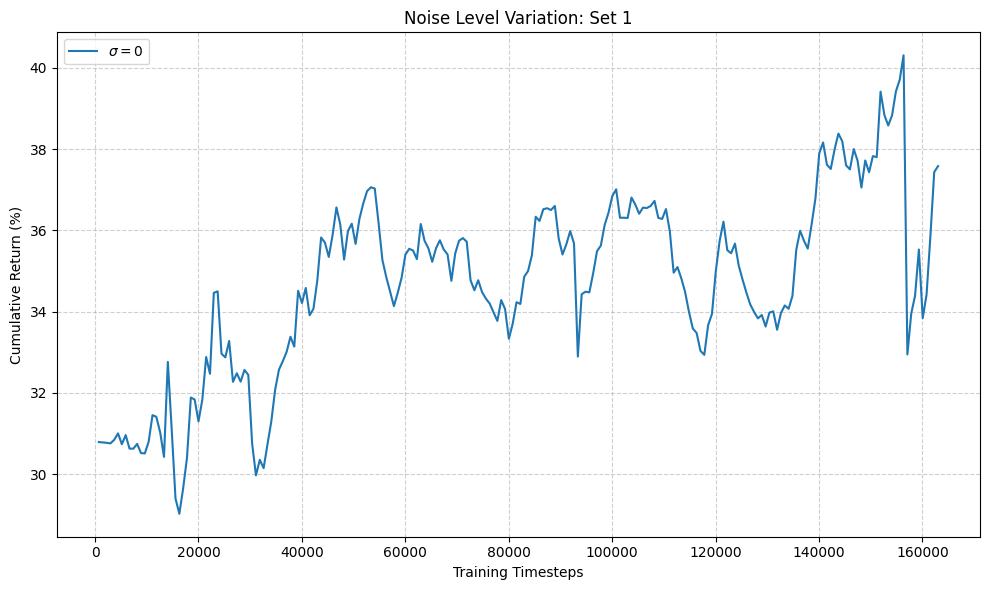

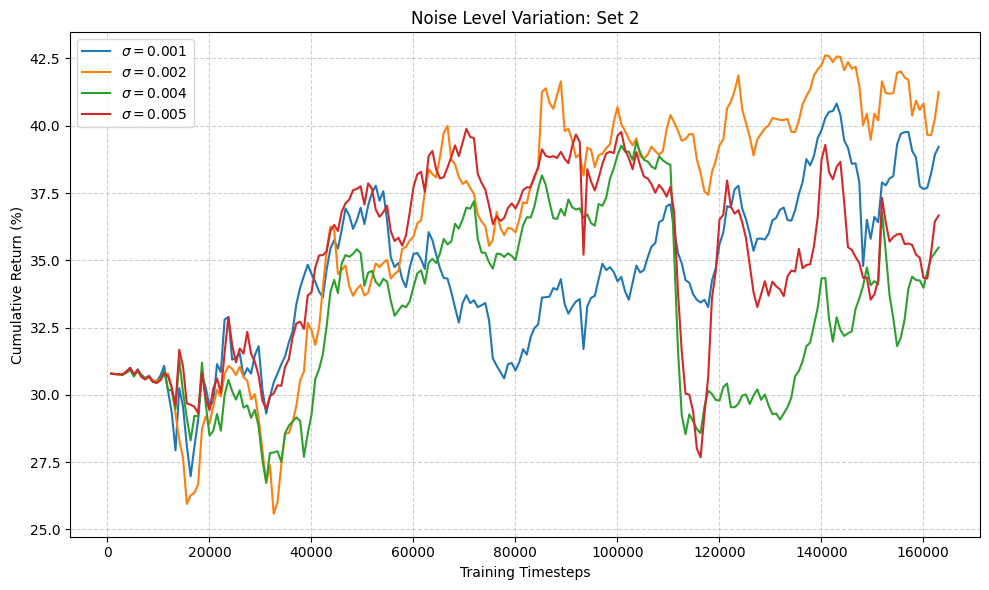

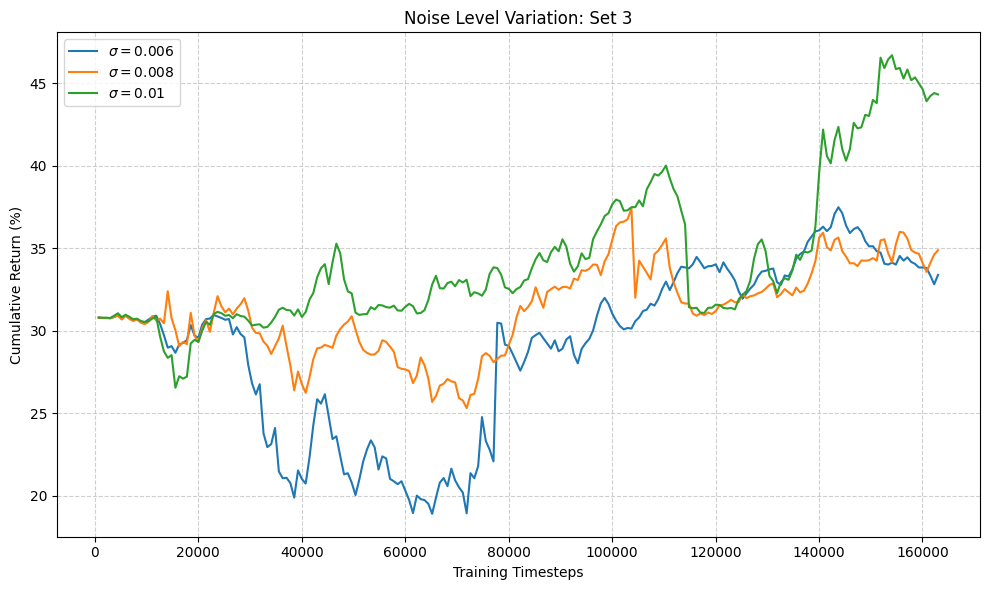

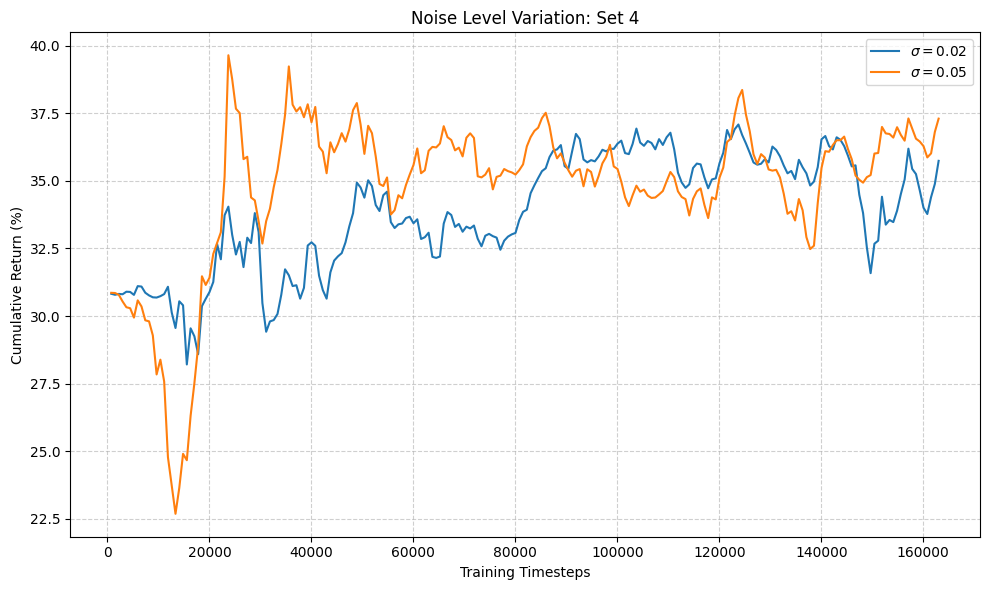

In [16]:
"""
Plotting code for the noise testing. 
"""
import numpy as np
import matplotlib.pyplot as plt
import os

if not os.path.exists("plots/"):
    os.makedirs("plots/")

SHOW_NOISE = True

noiseArr = [[0],[1e-3, 2e-3, 4e-3, 5e-3], [6e-3, 8e-3, 1e-2], [0.02, 0.05]]
WINDOW = 1  # no smoothing; increase if desired

if SHOW_NOISE:
    OLD_EPOCHS = 20  
    for i, arr in enumerate(noiseArr, start=1):
        plt.figure(figsize=(10, 6))  
        for value in arr:
            filePath = f"{folder}{value}.txt"
            array = (np.loadtxt(filePath) - 1) * 100  # percentage return

            if len(array) >= WINDOW:
                smoothed = np.convolve(array, np.ones(WINDOW)/WINDOW, mode='valid')
            else:
                smoothed = array

            # Convert episode index to timesteps
            xValues = np.linspace(WINDOW, OLD_EPOCHS * TRAINING_WINDOWS, len(smoothed)) * EPISODE_LENGTH

            plt.plot(xValues, smoothed, label=f"$\\sigma={value}$")

        plt.xlabel("Training Timesteps")
        plt.ylabel("Cumulative Return (%)") 
        plt.title(f"Noise Level Variation: Set {i}")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/NoiseSet_{i}")
        plt.show()


#### ~~4.4. Training Models~~

In [ ]:
def sweep():
    """
    Hyperparameter sweep function.

    For the active test defined in the TESTING dictionary, this function iterates over
    the corresponding hyperparameter values. For each value, it creates a configuration
    using getConfig (in the "hyperparameter_tuning" phase), generates an agent with generateAgent,
    and then calls trainingLoop with that agent and configuration.
    """
    # Map test types to their corresponding hyperparameter values and overrides.
    # For each override, if the value is None, then substitute the sweep value.
    sweep_params = {
        "RISK AVERSION": {
            "values": AGENT_RISK_AVERSIONS,
            "overrides": {"risk_aversion": None}
        },
        "LSTM OUTPUT SIZE": {
            "values": LSTMOUTPUTSIZES,
            "overrides": {"lstm_output_size": None}
        },
        "REWARD FUNCTION": {
            "values": REWARD_FUNCTIONS,
            "overrides": {"reward_function": None}
        },
        "LEARNING FREQUENCY": {
            "values": LEARNING_FREQUENCIES,
            "overrides": {"learning_frequency": None}
        },
        "LEARNING RATE": {
            "values": LEARNING_RATES,
            "overrides": {"learning_rate": None}
        }
    }
    phase = "hyperparameter_tuning"

    # Iterate over active test types defined in TESTING
    for testType, active in TESTING.items():
        if active and testType in sweep_params:
            param_info = sweep_params[testType]
            for value in param_info["values"]:
                print(f"Running sweep for {testType}: {value}")
                # Build the overrides dict, substituting sweep values where needed.
                overrides = {
                    key: (value if override is None else override)
                    for key, override in param_info["overrides"].items()
                }
                agentCfg = getConfig(phase, optionalHyperConfig=overrides)
                agent = generateAgent(agentCfg)

                wandb.init(project=PROJECT_NAME, config=agentCfg, name=f"exp-{phase}-{testType}-{value}", reinit=True)  
                config = wandb.config

                agent = generateAgent(config)

                if wandb.run is not None:
                    wandb.watch(agent.actor, log="all")
                    wandb.watch(agent.critic, log="all")
                    wandb.watch(agent.featureExtractor, log="all")

                trainingLoop(agent)
            break  # Run only one active test type per sweep


def hyperSweep():
    """
    Runs the hyperparameter sweep by sequentially activating one test type at a time.
    """
    for key in list(TESTING.keys()):
        print("=" * 50)
        TESTING[key] = True
        sweep()
        TESTING[key] = False
        print("=" * 50)


PERTURBATION_NOISE = 0  # temporary
EPOCHS = 3             
TRAIN = False           # Set to True to run the sweep

"""
NEEDS TO BE CHECKED TO ENSURE THE CONFIG IS CORRECT
"""

# Example usage:
if TRAIN:
    hyperSweep()

### 4.5. Evaluation

#### 4.5.0. Scoring Functions

In [ ]:
def maxDrawdown(arr):
    # Maximum Drawdown calculation
    maxValue = float("-inf")
    maxDrawdown = 0.0
    for value in arr:
        maxValue = max(maxValue, value)
        drawdown = (maxValue - value) / maxValue 
        maxDrawdown = max(maxDrawdown, drawdown)
    return maxDrawdown

#Scoring Formula
def scoreFormula(agentArray, averageRandomReturn):
    # score by (cumulative return - average random return)/max drawdown all times sharpe ratio
    cumulativeReturn = agentArray[-1] / START_CASH - 1
    maximumDrawdown = maxDrawdown(agentArray)
    percChange = np.diff(agentArray) / agentArray[:-1]
    sharpe = np.mean(percChange)/np.std(percChange) if np.std(percChange) != 0 else 0
    score = ((cumulativeReturn - averageRandomReturn) / maximumDrawdown) * sharpe
    metrics = {
        "Cumulative \nReturn (%)": cumulativeReturn * 100,
        "Maximum \nDrawdown (%)": maximumDrawdown * 100,
        "Sharpe Ratio": sharpe,
        "Score": score
    }
    return metrics


#### 4.5.1. Functions Called by 4.5.2

In [ ]:
NOISE_ITERATIONS_VALIDATION = 10

HYPERS = {
    "Risk Aversion" : AGENT_RISK_AVERSIONS,
    "LSTM Output Size" : LSTMOUTPUTSIZES,
    "Reward Function" : REWARD_FUNCTIONS,
    "Learning Frequency": LEARNING_FREQUENCIES, 
    "Learning Rate": LEARNING_RATES,
    }


def setParameters(parameter, hyper, riskAversion):
    """
    When Evaluating hyperparameters, this function is called to set the parameters of the agent.
    """
    rf = "Standard Logarithmic Returns"
    freq = int(EPISODE_LENGTH / 30)
    lr = 3e-4
    risk = parameter if hyper == "Risk Aversion" else riskAversion
    lstmOutputSize = 128
    if hyper == "Risk Aversion":
        agent = generateAgent(lstmOutputSize, parameter, lr, freq)
    elif hyper == "Learning Frequency":
        freq = parameter
        agent = generateAgent(lstmOutputSize, risk, lr, freq)
    elif hyper == "Reward Function":
        rf = parameter
        agent = generateAgent(lstmOutputSize, risk, lr, freq)
    elif hyper == "LSTM Output Size":
        agent = generateAgent(parameter, risk, lr, freq)
    elif hyper == "Learning Rate":
        lr = parameter
        agent = generateAgent(lstmOutputSize, risk, parameter, freq)
    return rf, freq, risk, agent, lr

def validationAgentsLoop(dataType, riskAversion, lr, noiseIteration, performances):
    """
    This just loops over every single hyperparameter and runs the evaluation function for each one.
    The performances dictionary stores the portfolio trajectory for each evaluation loop.
    """
    for hyper, param in HYPERS.items():
        TESTING[hyper.upper()] = True
        for epo in range(1, EPOCHS + 1):
            for parameter in param:
                saveFolder = f"save/{dataType}/{epo * TRAINING_WINDOWS}/{hyper}-{parameter}/"
                rf, freq, risk, agent, lr = setParameters(parameter, hyper, riskAversion)
                agent.load(saveFolder)
                portfolioValues = evaluateAgent(risk, rf, agent, freq, lr=lr, num=epo * TRAINING_WINDOWS, conf=None, save=False, epoch = noiseIteration) # ignore standard log - agent is not learning here
                performances[saveFolder].append(portfolioValues) 
        TESTING[hyper.upper()] = False

def testAgentsLoop(dataType, rewardFunctions, bestParams, performances):
    """
    This is a simpler loop that simply runs the evaluation function for each reward function.
    This is called later on to see how each checkpointed testing agent (saved at each epoch) performs on the test set.
    """
    for rewardFunc in rewardFunctions:
        TESTING["REWARD FUNCTION"] = True
        for epoch in range(1, EPOCHS + 1):
            saveFolder = f"save/{dataType}/{epoch*TRAINING_WINDOWS}/Reward Function-{rewardFunc}"
            agent = PPOAgent( 
                        state_n=bestParams["LSTM Output Size"], 
                        actions_n=len(productIds) + 1,
                        alpha=bestParams["Learning Rate"],
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=int(bestParams["Frequency"]),
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=1,
                        riskAversion=None,#not required for the agent
                        featureExtractor = LstmFeatureExtractor(NUMBER_OF_FEATURES, 128, bestParams["LSTM Output Size"]),
                        maxSize=bestParams["Frequency"],
                        nonFeatureStateDim = (TIME_WINDOW, NUMBER_OF_FEATURES),
                            )
            agent.load(saveFolder)
            portfolioValues = evaluateAgent("", rewardFunc, agent, "", "", epoch*TRAINING_WINDOWS, dataType=dataType, save=False, epoch=epoch, showTable = False)
            performances[saveFolder].append(portfolioValues) 
        TESTING["REWARD FUNCTION"] = False

def runSavedAgents(lstmOutputSize = 128, riskAversion=0, lr=3e-4, freq=int(EPISODE_LENGTH / 30), dataType = "validation", rewardFunctions = None, bestParams=None):
    performances = defaultdict(list)
    start = time.time()
    # Since noise is added only to the validation data, we don't need to run the test data for multiple iterations
    iters = NOISE_ITERATIONS_VALIDATION if dataType == "validation" else 1
    for noiseIteration in range(iters):
        # The number of validation iterations referred to earlier
        if noiseIteration > 0:
            print(f"{noiseIteration} Noise Iterations takes: {(time.time() - start):.2f} seconds")
        if dataType == "validation":
            validationAgentsLoop(dataType, riskAversion,  lr, noiseIteration, performances)
        else:
            testAgentsLoop(dataType, rewardFunctions, bestParams, performances)
    return performances
                
RUN_SAVED_TRAINED_AGENTS = False                

if RUN_SAVED_TRAINED_AGENTS:
    runSavedAgents()
        

#### 4.5.2.  Assess

In [ ]:
RANDOM_REPEATS = 1000

def runTestScoring(dataType, averageRandomReturn, performances, rewardFunc):
    """
    Essentially scores each final reward function model being tested.
    """
    table = [["Epoch/Model", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
    for epoch in range(1, EPOCHS + 1):
        key = f"save/{dataType}/{epoch*TRAINING_WINDOWS}/Reward Function-{rewardFunc}"
        portfolioNumbers = performances[key]
        portfolioNumbers = np.mean(np.array(portfolioNumbers), axis=0)
        metrics = scoreFormula(portfolioNumbers, averageRandomReturn)
        table.append([f"Epoch {epoch}"] + [round(met, 4) for met in metrics.values()])
    tabulate_neatly(table, headers="firstrow", title=f"Reward Function-{rewardFunc} | Scores and Metrics Tabulated (Test Set)")

def runValidationScoring(dataType, averageRandomReturn, performances, hyper=None, param=None):
    """
    Essentially scores each hyperparameter model being tested. This will take something like 30 minutes to run.
    It returns quite a few html tables, providing a score for every hyperparameter at each epoch it was trained at.
    """
    moreData = defaultdict(lambda: float("-inf"))
    epochNumber = defaultdict(lambda: 0)
    bestMetrics = {}  

    for epoch in range(1, EPOCHS + 1):
        table = [["Hyperparameter", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
        bestScore = float("-inf")
        bestParameter = None
        for parameter in param:
            key = f"save/{dataType}/{epoch * TRAINING_WINDOWS}/{hyper}-{parameter}/"
            portfolioNumbers = performances[key]
            portfolioNumbers = np.mean(np.array(portfolioNumbers), axis=0)
            metrics = scoreFormula(portfolioNumbers, averageRandomReturn)
            key = f"{hyper.title()}-{parameter}"
            if metrics["Score"] > moreData[key]:
                moreData[key] = metrics["Score"]
                epochNumber[key] = epoch
                bestMetrics[key] = metrics
            table.append([f"{hyper.title()}-{parameter}"] + [round(met, 4) for met in metrics.values()])
            if metrics["Score"] > bestScore:
                bestScore = metrics["Score"]
                bestParameter = f"{hyper.title()}-{parameter}"
        print(f"Epoch {epoch} | Best Hyperparameter: ", bestParameter)
        print(f"Epoch {epoch} | Best Score: ", bestScore)
        tabulate_neatly(table, headers="firstrow", title=f"Epoch: {epoch} | Scores and Metrics Tabulated")
    
    table2 = [["Hyperparameter", "Best Epoch", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
    for key in bestMetrics.keys():
        m = bestMetrics[key]
        table2.append([
            key,
            epochNumber[key],
            round(m["Cumulative \nReturn (%)"], 4),
            round(m["Maximum \nDrawdown (%)"], 4),
            round(m["Sharpe Ratio"], 4),
            round(m["Score"], 4)
        ])
    tabulate_neatly(table2, headers="firstrow", title=f"Best Hyperparameters with Detailed Metrics: {hyper.title()}")

def scoreAgents(dataType="validation", rewardFunctions=None, perfs = None, runAgents=True):
    """
    A higher level scoring function that calls eather runValidationScoring or runTestScoring depending on the dataType.
    It also runs the random agent as a benchmark for the what is being tested.
    The base seed for the random agent is only varied during testing. A limitation. However, this is consistent with 
    the methodology described in my report.
    """
    global BASE_SEED
    ORIGINAL_BASE_SEED = BASE_SEED
    averageRandomPerformance = []
    for bench in range(RANDOM_REPEATS):
        if dataType == "testing": # prior code bug. Last minute changes meant that I did not specify varying the random base seeed only for testing.
            if bench % (RANDOM_REPEATS // len(VARIED_BASE_SEEDS)) == 0 and VARIED_BASE_SEEDS:  
                BASE_SEED = VARIED_BASE_SEEDS.pop()
        randomArray = evaluateAgent("", "Standard Logarithmic Returns", "", "", lr="", num=0, conf=None, save=False, dataType=dataType, benchmark=True, epoch = bench) # added slr new (not necessary) error handling
        averageRandomPerformance.append(randomArray)
    averageRandomReturn = np.mean(np.array(averageRandomPerformance), axis=0)[-1] / START_CASH - 1
    forStd = np.std(np.array(averageRandomPerformance)[:, -1]) / START_CASH  
    print("RANDOM STD: ", forStd)
    averageRandomPerformance = np.mean(np.array(averageRandomPerformance), axis=0)
 
    # baseline
    metrics = scoreFormula(averageRandomPerformance, averageRandomReturn)
    table = [["Hyperparameter", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]] 
    table.append(["RANDOM"] + [round(met, 4) for met in metrics.values()])
    tabulate_neatly(table, headers="firstrow", title=f"Random Agent")
    if runAgents:
        if dataType == "validation":
            performances = runSavedAgents(dataType=dataType)
            for hyper, param in HYPERS.items():
                runValidationScoring(dataType, averageRandomReturn, performances, hyper, param)
        else:
            for rewardFunc in rewardFunctions:
                performances = perfs
                runTestScoring(dataType, averageRandomReturn, perfs, rewardFunc)
    return [averageRandomReturn, averageRandomPerformance]



"""
DID YOU SEED YOUR RUNS CORRECTLY
"""
GENERATE_SCORES = False
if GENERATE_SCORES:
    scoreAgents()

RANDOM STD:  0.07099710751766847


Random Agent

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
RANDOM,21.1466,10.8581,0.0818,0


1 Noise Iterations takes: 149.98 seconds
2 Noise Iterations takes: 306.80 seconds
3 Noise Iterations takes: 451.34 seconds
4 Noise Iterations takes: 605.22 seconds
5 Noise Iterations takes: 763.21 seconds
6 Noise Iterations takes: 914.87 seconds
7 Noise Iterations takes: 1072.30 seconds
8 Noise Iterations takes: 1223.25 seconds
9 Noise Iterations takes: 1376.60 seconds
Epoch 1 | Best Hyperparameter:  Risk Aversion-0.25
Epoch 1 | Best Score:  0.23939683437714804


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Risk Aversion-0.25,42.427,10.4306,0.1173,0.2394
Risk Aversion-0.5,31.6932,10.5376,0.1015,0.1016
Risk Aversion-1.0,40.1599,9.6733,0.1214,0.2385
Risk Aversion-1.5,35.0447,10.9238,0.1154,0.1468
Risk Aversion-2.0,24.7197,10.5637,0.084,0.0284


Epoch 2 | Best Hyperparameter:  Risk Aversion-1.0
Epoch 2 | Best Score:  0.1999690617785063


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Risk Aversion-0.25,37.7202,8.9463,0.1077,0.1996
Risk Aversion-0.5,30.815,9.5647,0.1028,0.1039
Risk Aversion-1.0,36.8677,9.4365,0.12,0.2
Risk Aversion-1.5,36.6128,10.8834,0.1207,0.1716
Risk Aversion-2.0,20.7509,11.3032,0.0711,-0.0025


Epoch 3 | Best Hyperparameter:  Risk Aversion-1.5
Epoch 3 | Best Score:  0.20588395526800424


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Risk Aversion-0.25,37.4158,9.3614,0.1119,0.1944
Risk Aversion-0.5,30.6912,10.6204,0.0988,0.0888
Risk Aversion-1.0,37.4835,9.7713,0.1182,0.1976
Risk Aversion-1.5,39.219,11.2662,0.1283,0.2059
Risk Aversion-2.0,27.0292,10.9012,0.0892,0.0481


Best Hyperparameters with Detailed Metrics: Risk Aversion

Hyperparameter,Best Epoch,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Risk Aversion-0.25,1,42.427,10.4306,0.1173,0.2394
Risk Aversion-0.5,2,30.815,9.5647,0.1028,0.1039
Risk Aversion-1.0,1,40.1599,9.6733,0.1214,0.2385
Risk Aversion-1.5,3,39.219,11.2662,0.1283,0.2059
Risk Aversion-2.0,3,27.0292,10.9012,0.0892,0.0481


Epoch 1 | Best Hyperparameter:  Lstm Output Size-32
Epoch 1 | Best Score:  0.3299992910254741


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Lstm Output Size-32,46.2262,10.8824,0.1432,0.33
Lstm Output Size-64,31.3296,11.5622,0.1038,0.0914
Lstm Output Size-128,49.2154,11.461,0.1291,0.3161
Lstm Output Size-256,43.408,12.2225,0.1233,0.2246
Lstm Output Size-512,40.286,13.4571,0.1184,0.1684


Epoch 2 | Best Hyperparameter:  Lstm Output Size-32
Epoch 2 | Best Score:  0.43319112357095146


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Lstm Output Size-32,50.3995,9.5552,0.1415,0.4332
Lstm Output Size-64,37.8728,10.3289,0.1051,0.1702
Lstm Output Size-128,47.087,13.1347,0.1239,0.2446
Lstm Output Size-256,35.1069,13.998,0.0983,0.098
Lstm Output Size-512,28.9808,11.8673,0.0974,0.0643


Epoch 3 | Best Hyperparameter:  Lstm Output Size-32
Epoch 3 | Best Score:  0.36988544754651237


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Lstm Output Size-32,47.212,10.0965,0.1433,0.3699
Lstm Output Size-64,47.8789,11.4596,0.1074,0.2505
Lstm Output Size-128,47.7532,12.8164,0.1284,0.2665
Lstm Output Size-256,37.7957,13.5373,0.1057,0.13
Lstm Output Size-512,31.4931,13.0951,0.1039,0.0821


Best Hyperparameters with Detailed Metrics: Lstm Output Size

Hyperparameter,Best Epoch,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Lstm Output Size-32,2,50.3995,9.5552,0.1415,0.4332
Lstm Output Size-64,3,47.8789,11.4596,0.1074,0.2505
Lstm Output Size-128,1,49.2154,11.461,0.1291,0.3161
Lstm Output Size-256,1,43.408,12.2225,0.1233,0.2246
Lstm Output Size-512,1,40.286,13.4571,0.1184,0.1684


Epoch 1 | Best Hyperparameter:  Reward Function-Differential Sharpe Ratio_0.05
Epoch 1 | Best Score:  0.08470680077681966


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Reward Function-Differential Sharpe Ratio_0.01,22.2106,13.2847,0.0672,0.0054
Reward Function-Differential Sharpe Ratio_0.05,29.3137,10.4191,0.1081,0.0847
Reward Function-Differential Sharpe Ratio_0.1,29.2943,10.3891,0.108,0.0847


Epoch 2 | Best Hyperparameter:  Reward Function-Differential Sharpe Ratio_0.05
Epoch 2 | Best Score:  0.08483288033726324


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Reward Function-Differential Sharpe Ratio_0.01,20.3181,10.3421,0.0651,-0.0052
Reward Function-Differential Sharpe Ratio_0.05,29.326,10.4137,0.108,0.0848
Reward Function-Differential Sharpe Ratio_0.1,29.2724,10.391,0.1078,0.0843


Epoch 3 | Best Hyperparameter:  Reward Function-Differential Sharpe Ratio_0.05
Epoch 3 | Best Score:  0.08614330257090957


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Reward Function-Differential Sharpe Ratio_0.01,17.5693,9.1959,0.0631,-0.0245
Reward Function-Differential Sharpe Ratio_0.05,29.4124,10.3968,0.1084,0.0861
Reward Function-Differential Sharpe Ratio_0.1,25.7285,15.5987,0.0801,0.0235


Best Hyperparameters with Detailed Metrics: Reward Function

Hyperparameter,Best Epoch,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Reward Function-Differential Sharpe Ratio_0.01,1,22.2106,13.2847,0.0672,0.0054
Reward Function-Differential Sharpe Ratio_0.05,3,29.4124,10.3968,0.1084,0.0861
Reward Function-Differential Sharpe Ratio_0.1,1,29.2943,10.3891,0.108,0.0847


Epoch 1 | Best Hyperparameter:  Learning Frequency-24
Epoch 1 | Best Score:  0.31610401943845884


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Frequency-73,8.1483,16.7534,0.033,-0.0256
Learning Frequency-36,43.6583,11.5813,0.1075,0.2089
Learning Frequency-24,49.2154,11.461,0.1291,0.3161
Learning Frequency-18,32.4555,13.7826,0.0936,0.0768
Learning Frequency-14,28.338,9.8354,0.0864,0.0632


Epoch 2 | Best Hyperparameter:  Learning Frequency-24
Epoch 2 | Best Score:  0.24463648725657322


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Frequency-73,10.6301,14.5806,0.0402,-0.029
Learning Frequency-36,40.5056,9.869,0.1118,0.2193
Learning Frequency-24,47.087,13.1347,0.1239,0.2446
Learning Frequency-18,34.5706,14.3083,0.0973,0.0913
Learning Frequency-14,31.6385,9.4229,0.1008,0.1122


Epoch 3 | Best Hyperparameter:  Learning Frequency-24
Epoch 3 | Best Score:  0.26654062450700794


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Frequency-73,12.9021,13.7746,0.0475,-0.0284
Learning Frequency-36,39.1675,10.374,0.1109,0.1926
Learning Frequency-24,47.7532,12.8164,0.1284,0.2665
Learning Frequency-18,38.023,11.5963,0.1099,0.16
Learning Frequency-14,29.9057,9.56,0.0952,0.0873


Best Hyperparameters with Detailed Metrics: Learning Frequency

Hyperparameter,Best Epoch,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Frequency-73,1,8.1483,16.7534,0.033,-0.0256
Learning Frequency-36,2,40.5056,9.869,0.1118,0.2193
Learning Frequency-24,1,49.2154,11.461,0.1291,0.3161
Learning Frequency-18,3,38.023,11.5963,0.1099,0.16
Learning Frequency-14,2,31.6385,9.4229,0.1008,0.1122


Epoch 1 | Best Hyperparameter:  Learning Rate-0.0003
Epoch 1 | Best Score:  0.31610401943845884


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Rate-0.0001,29.3534,10.4859,0.1078,0.0844
Learning Rate-0.0003,49.2154,11.461,0.1291,0.3161
Learning Rate-0.0005,36.1413,11.066,0.1237,0.1676
Learning Rate-0.0007,37.8811,9.7864,0.1006,0.1719


Epoch 2 | Best Hyperparameter:  Learning Rate-0.0003
Epoch 2 | Best Score:  0.24463648725657322


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Rate-0.0001,18.3978,11.4616,0.0689,-0.0165
Learning Rate-0.0003,47.087,13.1347,0.1239,0.2446
Learning Rate-0.0005,39.2254,11.0959,0.1307,0.213
Learning Rate-0.0007,36.214,8.7047,0.1009,0.1747


Epoch 3 | Best Hyperparameter:  Learning Rate-0.0005
Epoch 3 | Best Score:  0.2790726201494906


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Rate-0.0001,3.8538,14.9503,0.0179,-0.0207
Learning Rate-0.0003,47.7532,12.8164,0.1284,0.2665
Learning Rate-0.0005,41.8279,10.4998,0.1417,0.2791
Learning Rate-0.0007,38.075,9.5516,0.1014,0.1798


Best Hyperparameters with Detailed Metrics: Learning Rate

Hyperparameter,Best Epoch,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
Learning Rate-0.0001,1,29.3534,10.4859,0.1078,0.0844
Learning Rate-0.0003,1,49.2154,11.461,0.1291,0.3161
Learning Rate-0.0005,3,41.8279,10.4998,0.1417,0.2791
Learning Rate-0.0007,3,38.075,9.5516,0.1014,0.1798


## 5. Testing Process

### 5.1. Best Models (if any) Trained

In [ ]:
# Experiment 1
EXP_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1", "CVaR_0.25", "CVaR_1.0"],
                "LSTM Output Size" : 32, 
                "Frequency" : 24,
                "Learning Rate" : 3e-4,
                }

#this will actually test them too lol
def trainTestingAgents():
    TESTING["REWARD FUNCTION"] = True
    for r in EXP_CONFIG["Reward"]:
        trainingLoop(
            riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
            rewardFunction=r.split("_")[0] if "CVaR" in r else r,
            freq=EXP_CONFIG["Frequency"],
            lstmOutputSize=EXP_CONFIG["LSTM Output Size"],
            lr=EXP_CONFIG["Learning Rate"],
            conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM",
            evalType = "testing"
        )
    TESTING["REWARD FUNCTION"] = False

TRAINING_WINDOWS = ((TRAINING_PERIODS + VALIDATION_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1
SUM_TRAINING_PERIODS = TRAINING_WINDOWS * EPOCHS * (EPISODE_LENGTH - TIME_WINDOW) # because first time window steps are not used to learn
LEARNING_CURVE_FREQUENCY = SUM_TRAINING_PERIODS // 100

"""
Takes something like 45 Minutes per seed to run on my laptop.
"""

"""
DID YOU SEED YOUR RUNS CORRECTLY
"""
# RUN_FINAL = False
# VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]
# if RUN_FINAL:
#     for base in VARIED_BASE_SEEDS:
#         BASE_SEED = base #Vary the base seed for the reward tests.
#         trainTestingAgents()
    


KeyboardInterrupt: 

### 5.2. Per-epoch performance Analysis

In [ ]:
"""
This will run the test agents on the test set and return the portfolio values for each agent.
It runs relatively quickly, less than a minute, since it is not training the agents, just running them on the test set.
"""
RUN_EPOCH_AGENTS = False
if RUN_EPOCH_AGENTS:
    formances = runSavedAgents(dataType="testing", rewardFunctions=EXP_CONFIG["Reward"], bestParams=EXP_CONFIG)

"""This is the final testing code. It runs the saved agents on the test set and 
returns the perdformance metrics of the random agent which is used later.
Provided you have run the above cell, and have agents saved, this should take about 2 minutes to run"""
avRandReturn, averPerformance = scoreAgents("testing", rewardFunctions=EXP_CONFIG["Reward"], perfs = formances if RUN_EPOCH_AGENTS else None, runAgents=False)

STD:  0.09503904109732429


Random Agent

Hyperparameter,Cumulative Return (%),Maximum Drawdown (%),Sharpe Ratio,Score
RANDOM,25.8237,25.5689,0.0577,0


### 5.3. Learning Curves

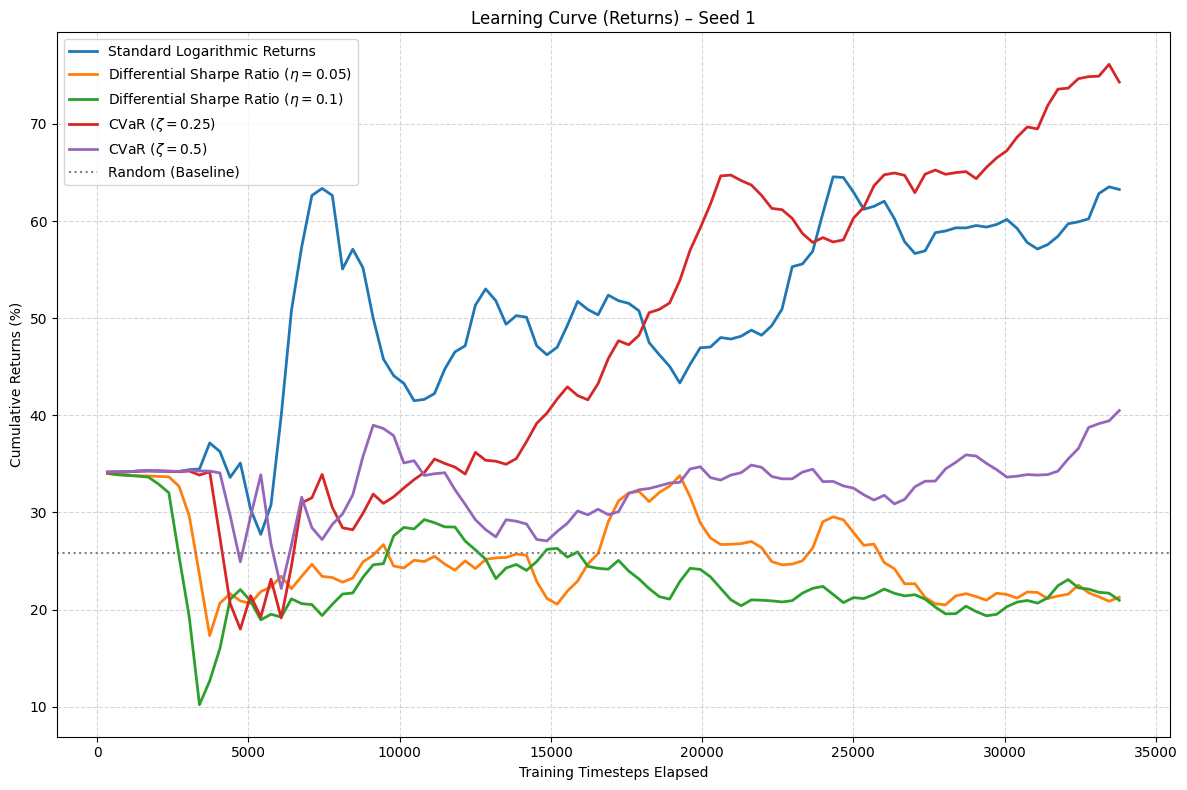

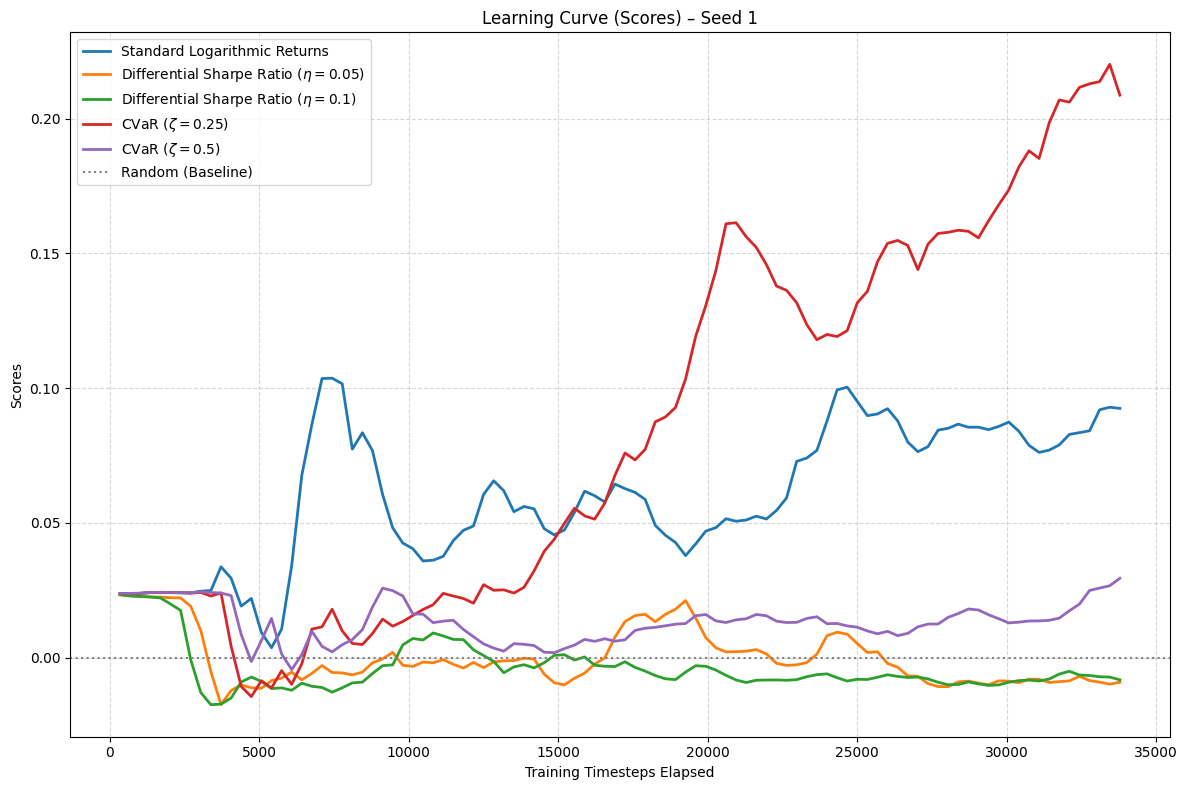

Seed 1: Best Agents and Their Test-Set Performance

Reward Function,Cumulative Return,Maximum Drawdown,Sharpe Ratio,Score,Training Timesteps Elapsed
Standard Logarithmic Returns,63.3577,31.96,0.0883076,0.103709,7434
Differential Sharpe Ratio = 0.05,34.0044,25.2758,0.0718707,0.0232616,337
Differential Sharpe Ratio = 0.1,34.0363,25.273,0.0719351,0.0233758,337
CVaR = 0.25,76.1274,25.1815,0.110226,0.220191,33454
CVaR = 0.5,40.4893,34.005,0.0682775,0.0294467,33792


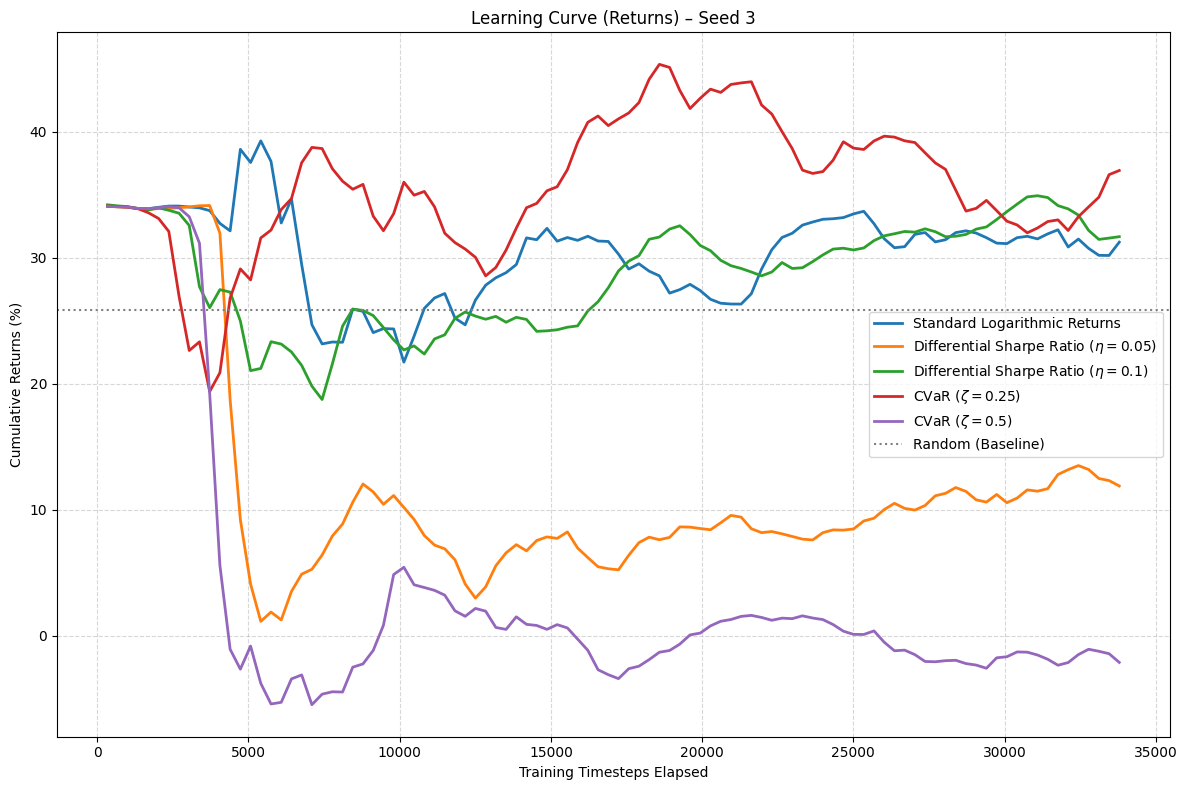

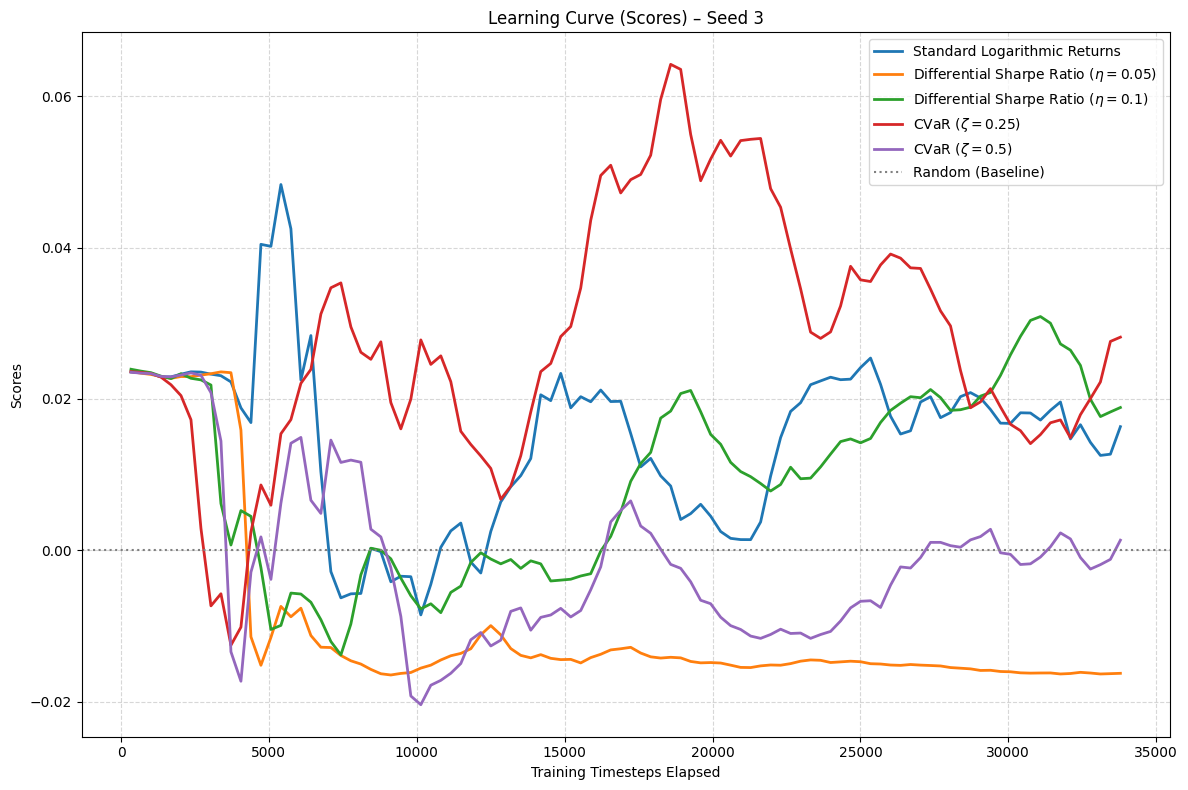

Seed 3: Best Agents and Their Test-Set Performance

Reward Function,Cumulative Return,Maximum Drawdown,Sharpe Ratio,Score,Training Timesteps Elapsed
Standard Logarithmic Returns,39.2893,22.2039,0.079695,0.0483312,5406
Differential Sharpe Ratio = 0.05,34.115,25.2923,0.0720431,0.0236174,337
Differential Sharpe Ratio = 0.1,34.9318,22.8668,0.0775443,0.030887,31088
CVaR = 0.25,45.367,25.7382,0.0845638,0.0642104,18585
CVaR = 0.5,34.0866,25.2897,0.0719992,0.0235244,337


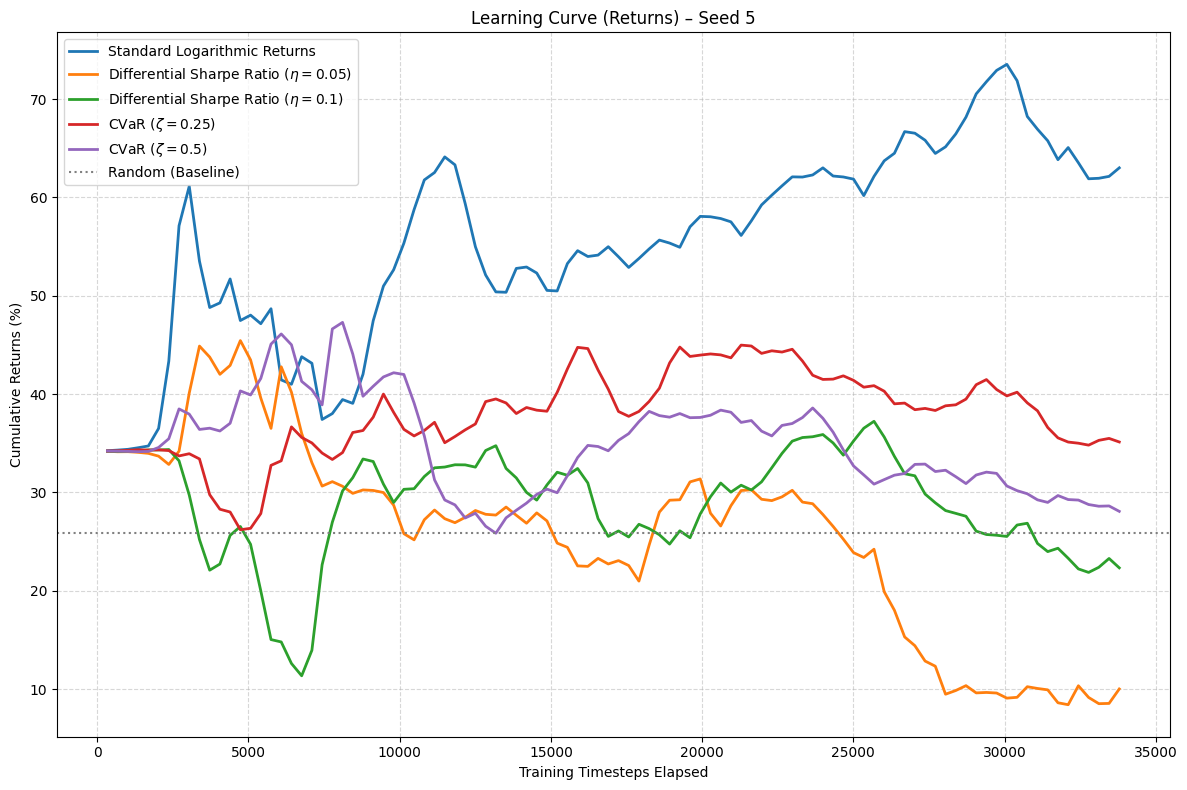

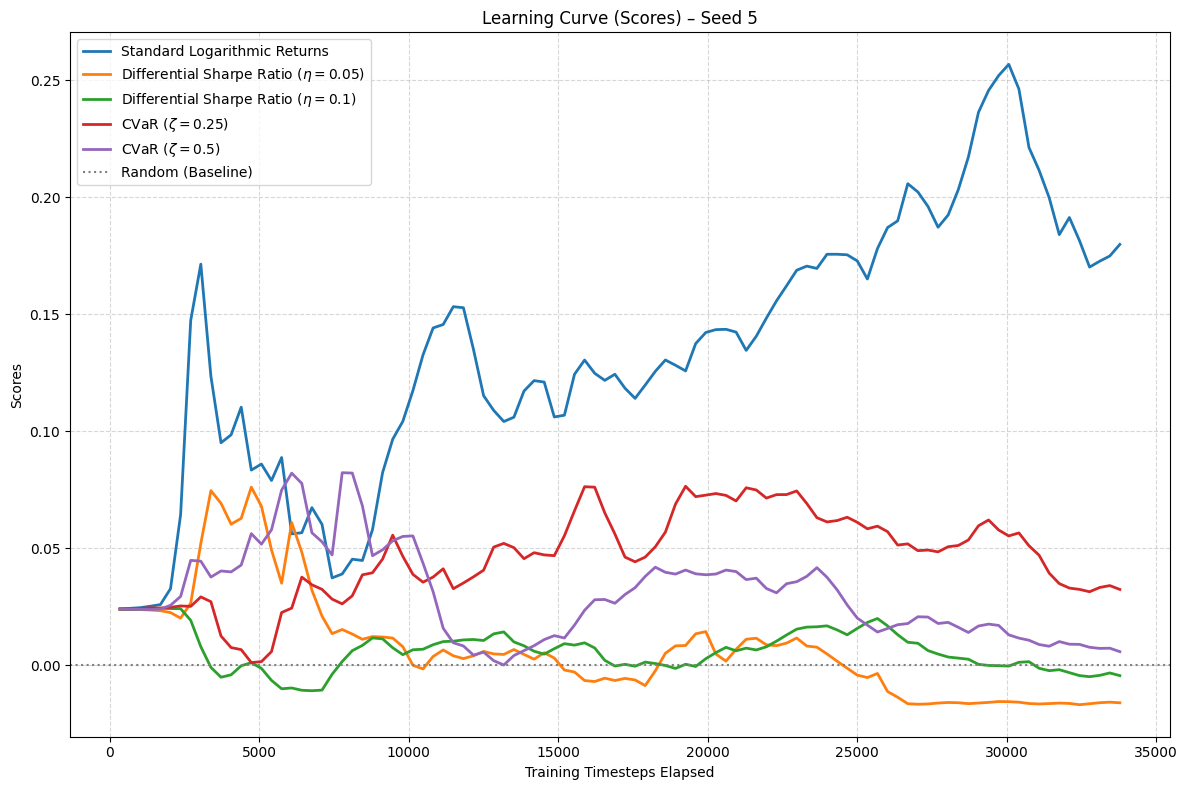

Seed 5: Best Agents and Their Test-Set Performance

Reward Function,Cumulative Return,Maximum Drawdown,Sharpe Ratio,Score,Training Timesteps Elapsed
Standard Logarithmic Returns,73.5278,22.2506,0.119749,0.256736,30074
Differential Sharpe Ratio = 0.05,45.4356,22.5036,0.0872666,0.0760527,4730
Differential Sharpe Ratio = 0.1,34.3176,25.306,0.0723752,0.0242927,1689
CVaR = 0.25,44.7759,21.8487,0.0880977,0.0764187,19261
CVaR = 0.5,46.6208,21.7347,0.0859305,0.0822238,7772


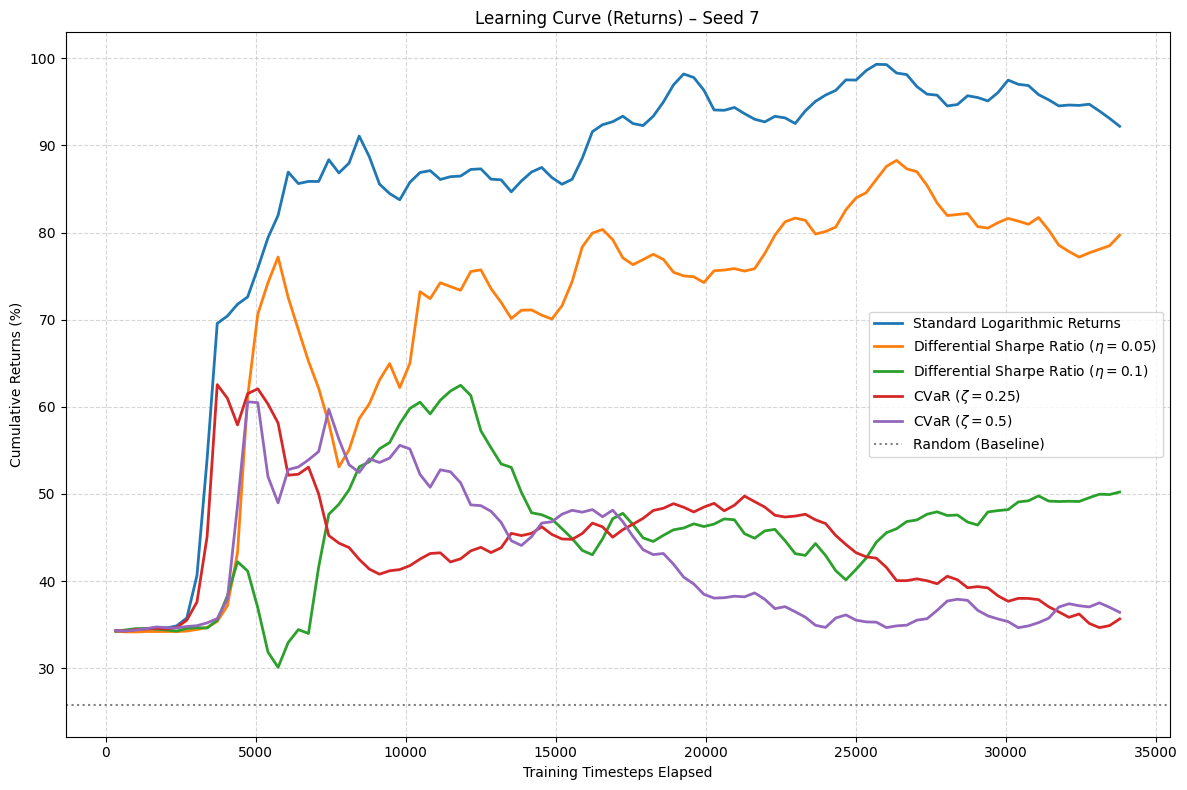

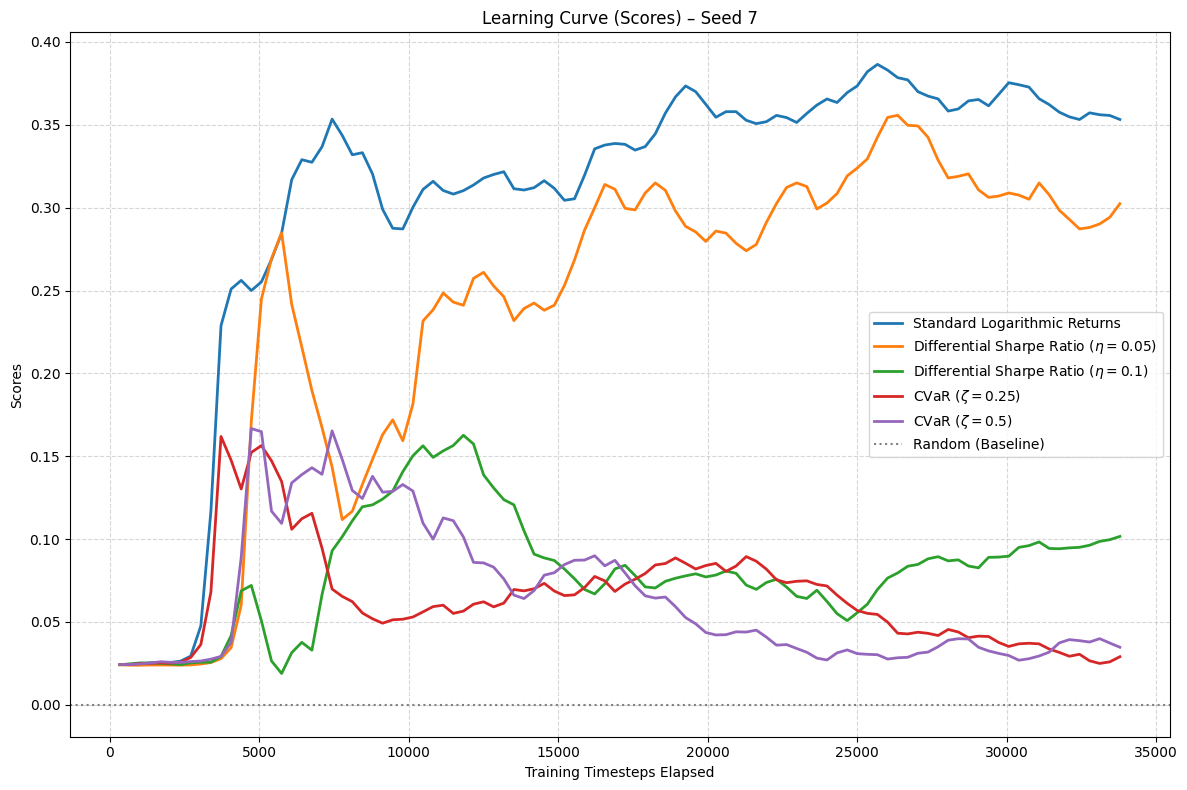

Seed 7: Best Agents and Their Test-Set Performance

Reward Function,Cumulative Return,Maximum Drawdown,Sharpe Ratio,Score,Training Timesteps Elapsed
Standard Logarithmic Returns,99.2946,25.1714,0.132416,0.386499,25681
Differential Sharpe Ratio = 0.05,88.2721,23.3161,0.132824,0.355748,26357
Differential Sharpe Ratio = 0.1,62.4747,24.296,0.107801,0.16262,11827
CVaR = 0.25,62.5504,24.6132,0.108498,0.161895,3717
CVaR = 0.5,60.5752,23.0598,0.110606,0.166685,4730


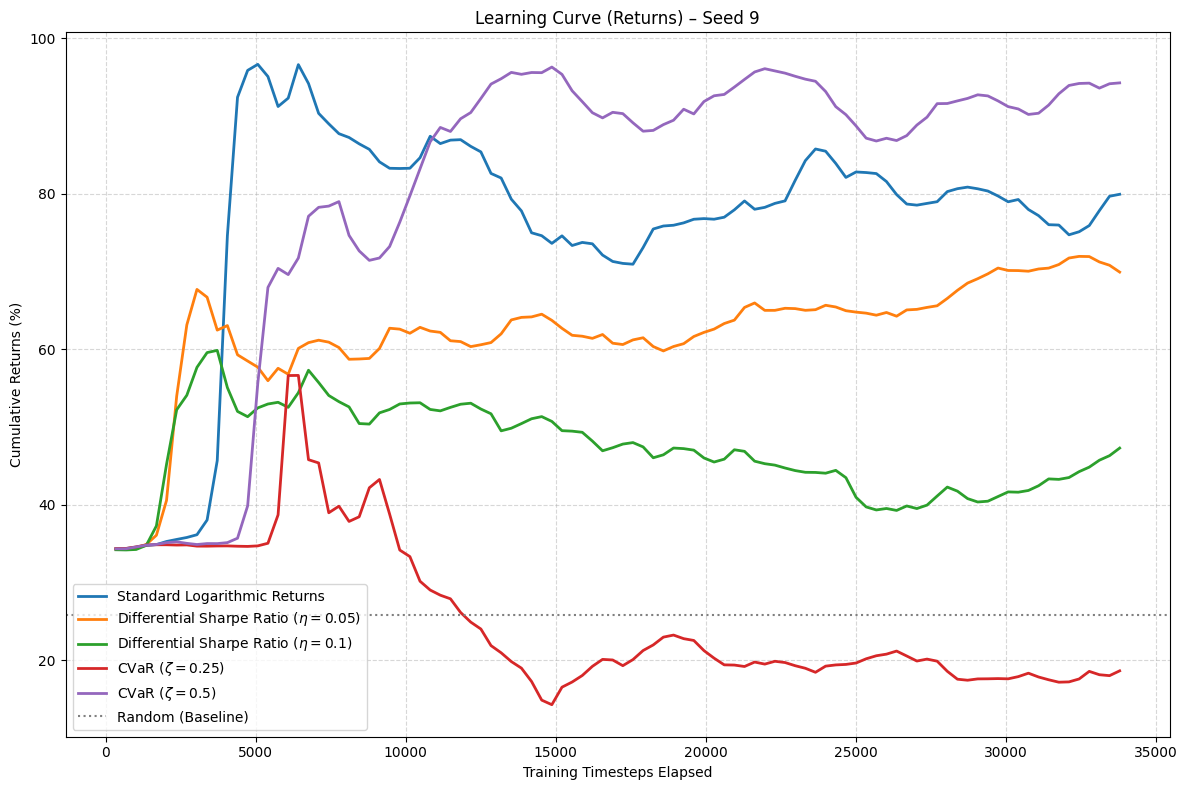

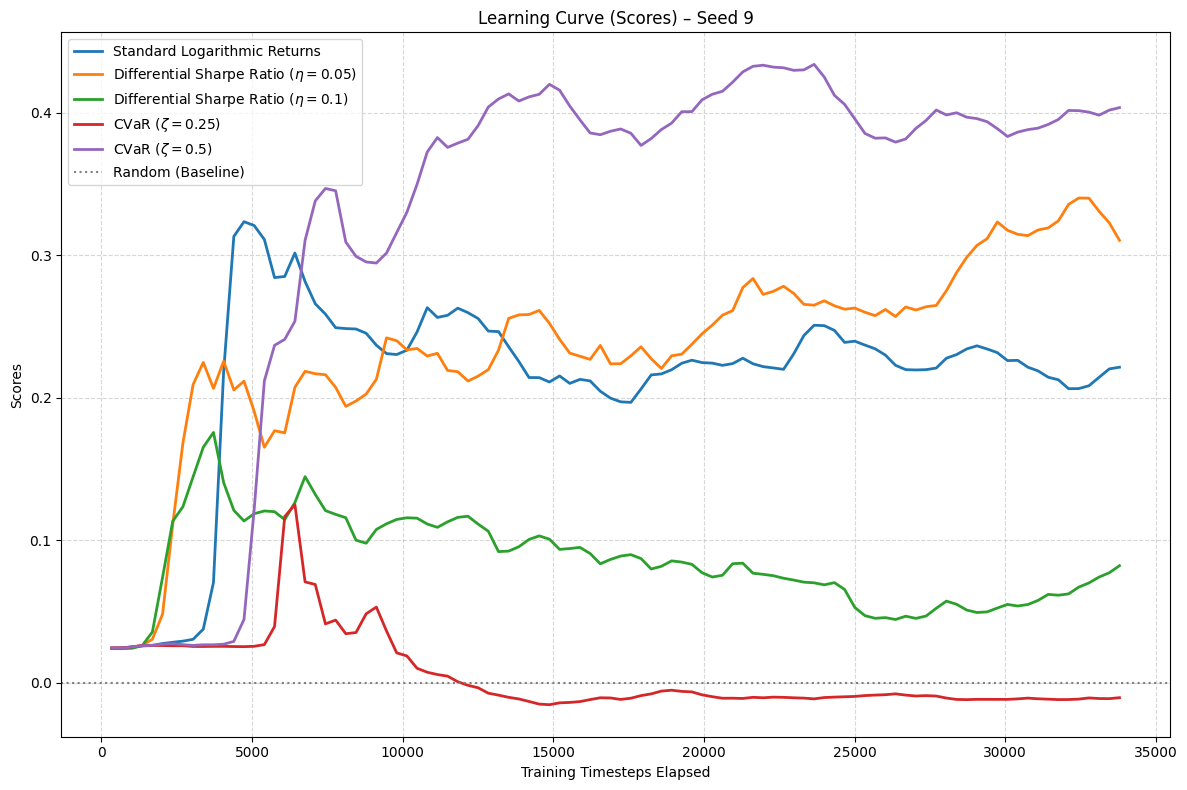

Seed 9: Best Agents and Their Test-Set Performance

Reward Function,Cumulative Return,Maximum Drawdown,Sharpe Ratio,Score,Training Timesteps Elapsed
Standard Logarithmic Returns,95.8867,27.2383,0.125804,0.323596,4730
Differential Sharpe Ratio = 0.05,71.9488,17.4367,0.128614,0.34022,32440
Differential Sharpe Ratio = 0.1,59.8531,21.6767,0.111892,0.175655,3717
CVaR = 0.25,56.6294,24.3969,0.0989545,0.124948,6420
CVaR = 0.5,94.4842,22.3289,0.141156,0.434049,23654


In [ ]:
from itertools import cycle


portVals = dict()
FIG_SIZE = (12, 8)
for strat in NON_RL_COMPARISON_STRATEGIES:
    portVals[strat] = evaluateAgent("", "", "", "", "", "", conf=None, save=True, dataType = "testing", forLearningCurve=False, benchmark=False, epoch=0, showTable=False, compare=strat)
    
bestTestSetPerformance = dict()
WINDOW = 1 # raw
VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]


"""
The below code generates more metrics and plots for the test set performance of the agents.
"""
def plotAllCurves(rewardFunctions):
    for seed in VARIED_BASE_SEEDS:
        cumulativeReturnsData = {}
        scoresData = {}
        timeSteps = []

        for rewardFunc in rewardFunctions:
            file = f"portfolios/testing/forLearningCurve{seed}/Reward Function-{rewardFunc}_"
            cumReturns = []
            scores = []
            for i in range(1, 101):
                key = f"{file}{i}.txt"
                values = np.loadtxt(key)
                metrics = scoreFormula(values, avRandReturn)
                cumReturns.append(metrics["Cumulative \nReturn (%)"])
                scores.append(metrics["Score"])
                if len(timeSteps) < 100:
                    timeSteps.append(i / 100 * SUM_TRAINING_PERIODS)
            cumulativeReturnsData[rewardFunc] = cumReturns
            scoresData[rewardFunc] = scores
            bestPercentThrough = np.argmax(scores)
            bestTestSetPerformance[(rewardFunc, seed)] = [
                max(cumReturns),
                scores[bestPercentThrough],
                int(timeSteps[bestPercentThrough])
            ]
            bestTestSetPerformance[(rewardFunc, seed)].append(np.loadtxt(f"{file}{bestPercentThrough + 1}.txt"))

        # Plot cumulative returns for this seed
        plt.figure(figsize=FIG_SIZE)
        for rewardFunc, cumReturns in cumulativeReturnsData.items():
            properName = rewardFunc.split('_')
            if len(properName) > 1:
                if "CVaR" in properName[0]:
                    plottedName = f"CVaR ($\\zeta={properName[1]}$)"
                elif "Differential Sharpe Ratio" in properName[0]:
                    plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
                else:
                    plottedName = f"{properName[0]} ({properName[1]})"
            else:
                plottedName = properName[0]
            smoothedReturns = np.convolve(cumReturns, np.ones(WINDOW)/WINDOW, mode='valid')
            plt.plot(timeSteps, np.append(cumReturns[:WINDOW-1], smoothedReturns),
                     label=plottedName, linewidth=2)
        plt.axhline(y=avRandReturn*100, color='grey', linestyle=':', label="Random (Baseline)", linewidth=1.5)
        plt.xlabel("Training Timesteps Elapsed")
        plt.ylabel("Cumulative Returns (%)")
        plt.title(f"Learning Curve (Returns) – Seed {seed}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/Cumulative_Returns_Seed{seed}")
        plt.show()

        # Plot scores for this seed
        plt.figure(figsize=FIG_SIZE)
        for rewardFunc, scores in scoresData.items():
            properName = rewardFunc.split('_')
            if len(properName) > 1:
                if "CVaR" in properName[0]:
                    plottedName = f"CVaR ($\\zeta={properName[1]}$)"
                elif "Differential Sharpe Ratio" in properName[0]:
                    plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
                else:
                    plottedName = f"{properName[0]} ({properName[1]})"
            else:
                plottedName = properName[0]
            smoothedScores = np.convolve(scores, np.ones(WINDOW)/WINDOW, mode='valid')
            plt.plot(timeSteps, np.append(scores[:WINDOW-1], smoothedScores),
                     label=plottedName, linewidth=2)
        plt.axhline(y=0, color='grey', linestyle=':', label="Random (Baseline)", linewidth=1.5)
        plt.xlabel("Training Timesteps Elapsed")
        plt.ylabel("Scores")
        plt.title(f"Learning Curve (Scores) – Seed {seed}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/Scores_Seed{seed}")
        plt.show()

        # Tabulate best agents for this seed
        table = [["Reward Function", "Cumulative Return", "Maximum Drawdown", "Sharpe Ratio", "Score", "Training Timesteps Elapsed"]]
        for rewardFunc in EXP_CONFIG["Reward"]:
            properName = rewardFunc.split('_')
            tabulatedName = f"{properName[0] + (f' = {properName[1]}' if len(properName) > 1 else '')}"
            metrics = scoreFormula(bestTestSetPerformance[(rewardFunc, seed)][-1], avRandReturn)
            table.append([
                tabulatedName, 
                metrics["Cumulative \nReturn (%)"], 
                metrics["Maximum \nDrawdown (%)"], 
                metrics["Sharpe Ratio"],
                metrics["Score"], 
                bestTestSetPerformance[(rewardFunc, seed)][2]
            ])
        tabulate_neatly(table, headers="firstrow", title=f"Seed {seed}: Best Agents and Their Test-Set Performance")




plotAllCurves(EXP_CONFIG["Reward"])


plt.figure(figsize=(10, 6))
availableColors = ['purple', 'darkgreen', 'darkgray', 'black', 'navy']
colorCycle = cycle(availableColors) 

for seed in VARIED_BASE_SEEDS:
    for rewardFunc in EXP_CONFIG["Reward"]:
        properName = rewardFunc.split('_')
        plottedName = f"{properName[0] + (f" = {properName[1]}" if len(properName) > 1 else "")}"
        plt.plot(np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100, label=f"{plottedName}")
plt.ylabel("Cumulative Returns (%)")
plt.xlabel("Time")
plt.title("Cumulative Returns On Test Set")

plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")
for key, value in portVals.items():
    color = next(colorCycle)  
    plt.plot(np.array(value) / START_CASH * 100 - 100, label=key, color=color)

plt.legend()
# plt.savefig("plots/BestRawReturnsAll")
# plt.show()
plt.close()
 
#########################################################################################################


### 5.4 Best Performances and Standard Deviations

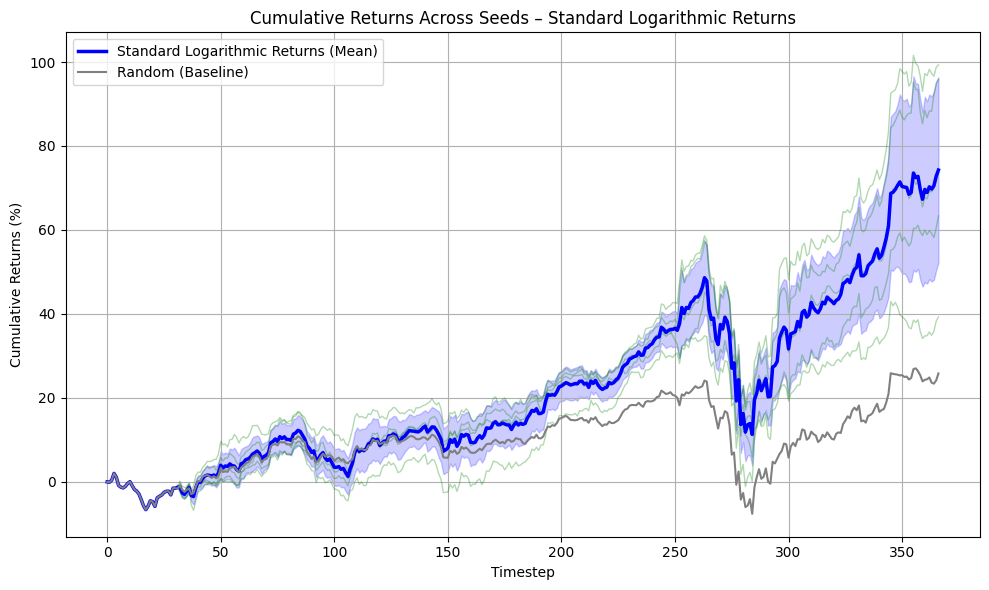

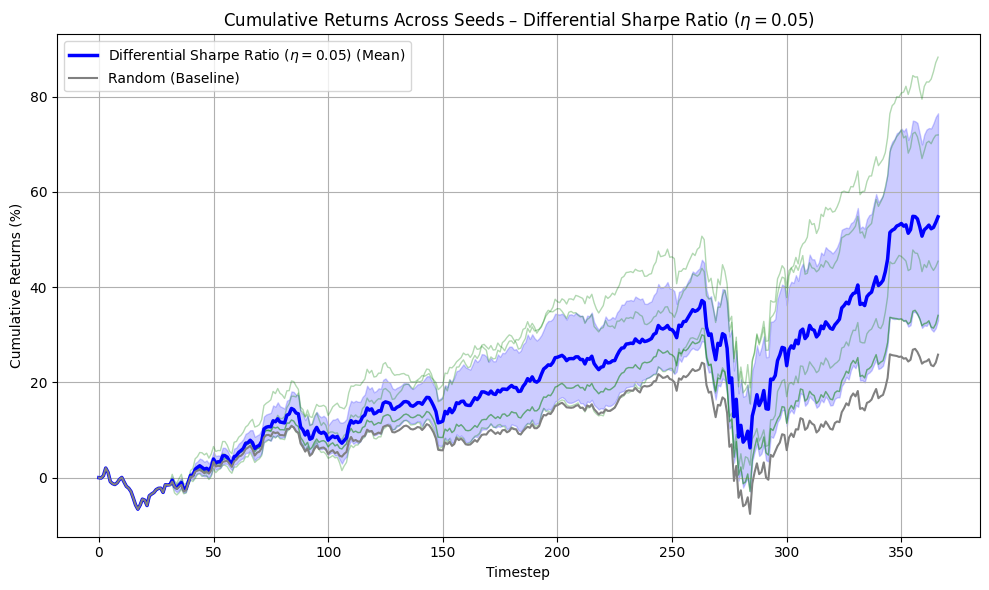

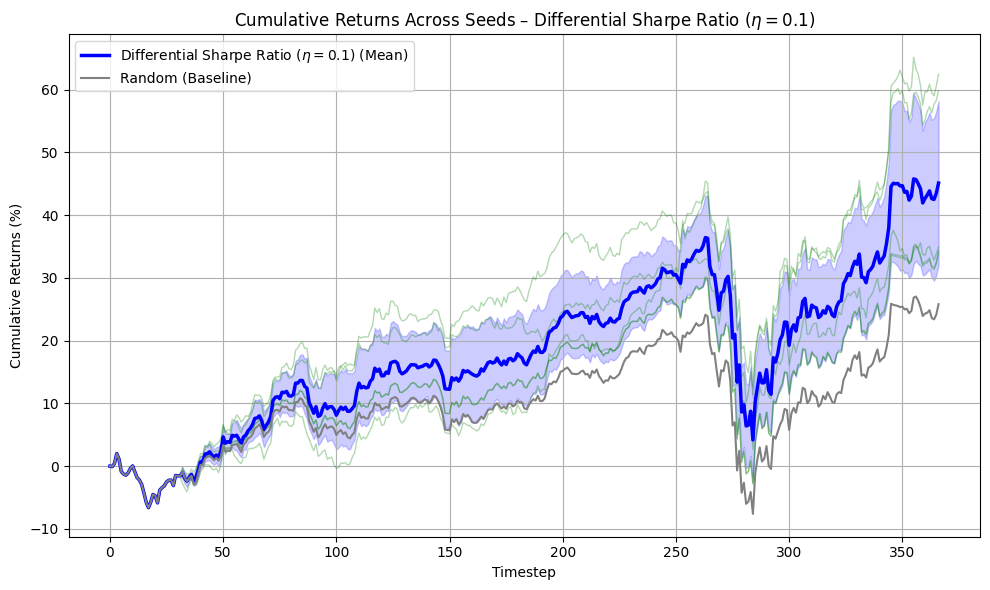

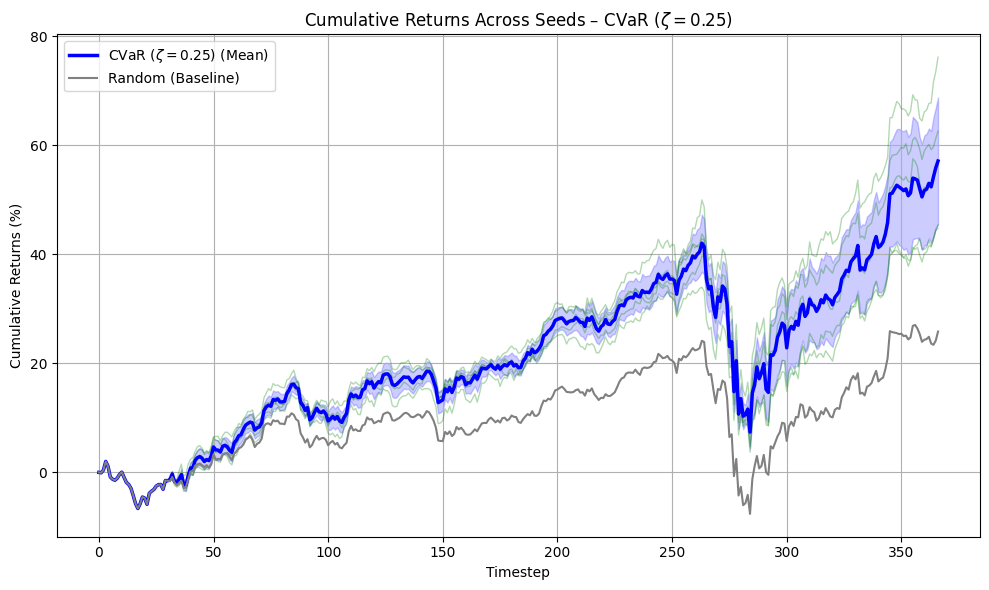

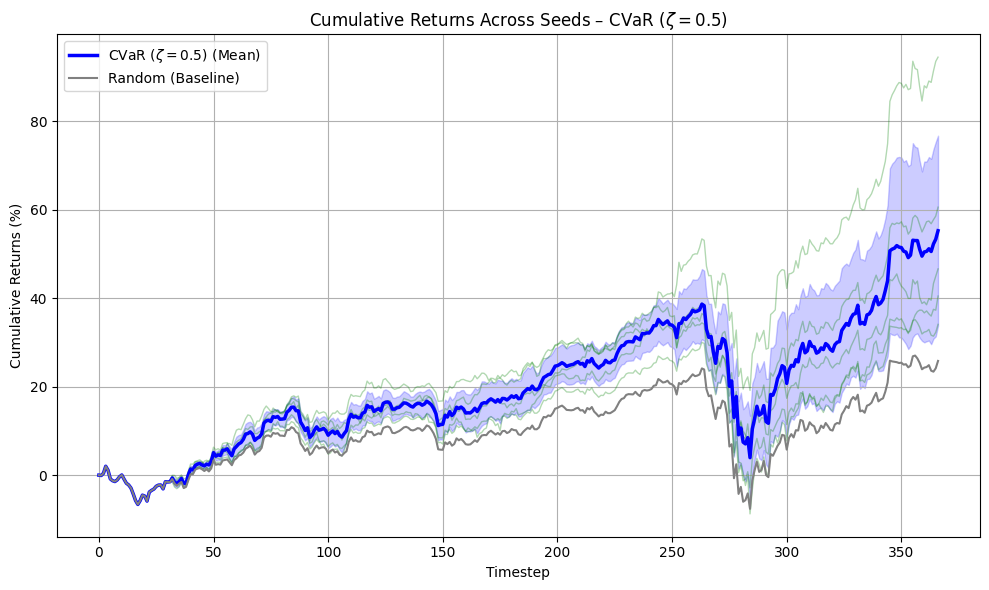

In [ ]:

for rewardFunc in EXP_CONFIG["Reward"]:
    allTrajectories = []
    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100
        allTrajectories.append(traj)

    # Convert to array for mean/std computation
    allTrajectories = np.array(allTrajectories)
    meanTrajectory = np.mean(allTrajectories, axis=0)
    std_traj = np.std(allTrajectories, axis=0)
    timesteps = np.arange(len(meanTrajectory))

    # Format name for legend and title
    properName = rewardFunc.split('_')
    if len(properName) > 1:
        if "CVaR" in properName[0]:
            plottedName = f"CVaR ($\\zeta={properName[1]}$)"
        elif "Differential Sharpe Ratio" in properName[0]:
            plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
        else:
            plottedName = f"{properName[0]} ({properName[1]})"
    else:
        plottedName = properName[0]

    # Plot
    plt.figure(figsize=(10, 6))
    for traj in allTrajectories:
        plt.plot(timesteps, traj, color='green', alpha=0.3, linewidth=1)  # Faint individual runs
    plt.plot(timesteps, meanTrajectory, color='blue', label=f"{plottedName} (Mean)", linewidth=2.5)
    plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")
    plt.fill_between(timesteps, meanTrajectory - std_traj, meanTrajectory + std_traj, color='blue', alpha=0.2)
    # Clean filename string: replace space, dot, brackets, equal signs

    safe_filename = rewardFunc.replace(' ', '_').replace('=', '').replace('(', '').replace(')', '').replace('.', '_')

    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Returns (%)")
    plt.title(f"Cumulative Returns Across Seeds – {plottedName}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/Cumulative_Returns_Mean_{safe_filename}")
    plt.show()


### 5.5 Means and Index Comparisons

In [ ]:
meanStdPerReward = {}

for rewardFunc in EXP_CONFIG["Reward"]:
    allTrajectories = []
    mdds = []
    sharpes = []
    scores = []

    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1])
        normTraj = traj / START_CASH * 100 - 100  # Percentage returns for plotting
        allTrajectories.append(normTraj)

        # Compute MDD and Sharpe on raw values
        raw = traj
        
        mdd = maxDrawdown(raw) * 100  # convert to percent
        returns = np.diff(raw) / raw[:-1]
        sharpe = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0

        mdds.append(mdd)
        sharpes.append(sharpe)
        metrs = scoreFormula(traj, avRandReturn)
        scores.append(metrs["Score"])

    allTrajectories = np.array(allTrajectories)
    mean_traj = np.mean(allTrajectories, axis=0)
    std_traj = np.std(allTrajectories, axis=0)

    meanStdPerReward[rewardFunc] = {
        "mean_trajectory": mean_traj,
        "std_trajectory": std_traj,
        "final_mean_return": mean_traj[-1],
        "final_std_dev": np.std([traj[-1] for traj in allTrajectories]),
        "mean_mdd": np.mean(mdds),
        "mean_sharpe": np.mean(sharpes),
        "mean_score": np.mean(scores),
    }

# Optional: print or tabulate results
indexComparisonTable = [["Reward Function", "Final Mean Return (%)", "Std Dev (%)", "Mean MDD (%)", "Mean Sharpe", "Mean Score"]]
for rewardFunc in EXP_CONFIG["Reward"]:
    properName = rewardFunc.replace("_", " = ") if "_" in rewardFunc else rewardFunc
    stats = meanStdPerReward[rewardFunc]
    indexComparisonTable.append([
        properName,
        round(stats["final_mean_return"], 4),
        round(stats["final_std_dev"], 4),
        round(stats["mean_mdd"], 4),
        round(stats["mean_sharpe"], 4),
        round(stats["mean_score"], 4)
    ])

tabulate_neatly(indexComparisonTable, headers="firstrow", title="Mean Statistics Across Seeds")



Mean Statistics Across Seeds

Reward Function,Final Mean Return (%),Std Dev (%),Mean MDD (%),Mean Sharpe,Mean Score
Standard Logarithmic Returns,74.2712,22.0762,25.7648,0.1092,0.2238
Differential Sharpe Ratio = 0.05,54.7552,21.7369,22.7649,0.0985,0.1638
Differential Sharpe Ratio = 0.1,45.1227,13.127,23.8837,0.0883,0.0834
CVaR = 0.25,57.09,11.6749,24.3557,0.0981,0.1295
CVaR = 0.5,55.2512,21.4844,25.2836,0.0956,0.1472


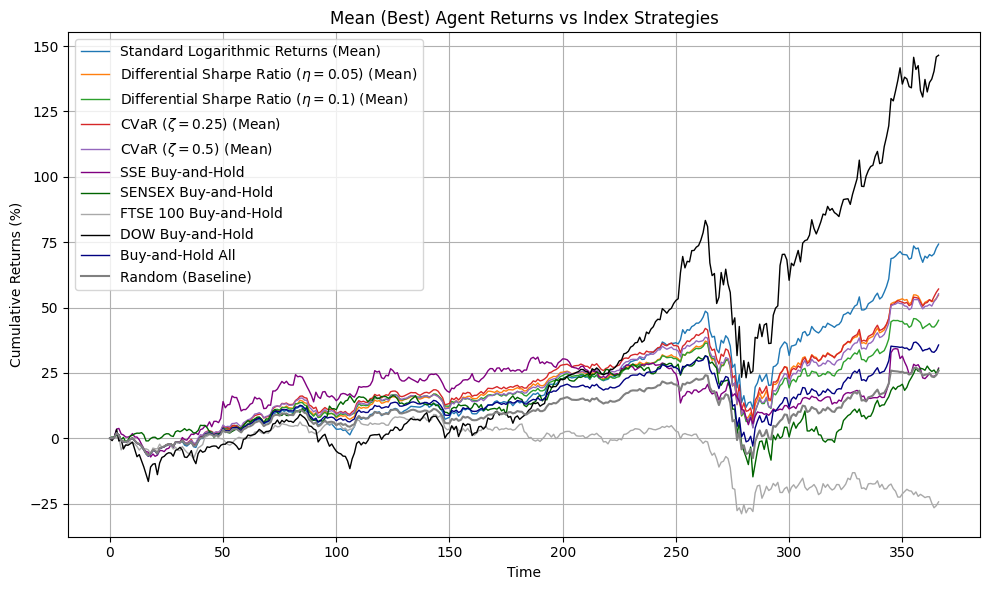

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

# Define figure and color cycle
plt.figure(figsize=(10, 6))
availableColors = ['purple', 'darkgreen', 'darkgray', 'black', 'navy']
colorCycle = cycle(availableColors)

# Plot mean RL trajectories across seeds
for rewardFunc in EXP_CONFIG["Reward"]:
    allTrajectories = []
    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100
        allTrajectories.append(traj)
    meanTrajectory = np.mean(allTrajectories, axis=0)
    timesteps = np.arange(len(meanTrajectory))

    # Format name for legend
    properName = rewardFunc.split('_')
    if len(properName) > 1:
        if "CVaR" in properName[0]:
            plottedName = f"CVaR ($\\zeta={properName[1]}$)"
        elif "Differential Sharpe Ratio" in properName[0]:
            plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
        else:
            plottedName = f"{properName[0]} ({properName[1]})"
    else:
        plottedName = properName[0]

    plt.plot(timesteps, meanTrajectory, label=f"{plottedName} (Mean)", linewidth=1)

# Plot index strategies from portVals with custom dash style
for key, value in portVals.items():
    traj = np.array(value) / START_CASH * 100 - 100
    color = next(colorCycle)
    plt.plot(traj, label=key, color=color, linewidth=1)
plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")


# Add baseline and labels
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (%)")
plt.title("Mean (Best) Agent Returns vs Index Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Mean_Returns_vs_Indices")
plt.show()
